# Heat, Cold, and Conflict: Exploring the Link Between Weather Conditions and Domestic Crime in Chicago.

# Project One

## 1.1 Introduction

This project investigates the relationship between weather conditions and domestic crime in Chicago from 2010 to 2020, specifically examining how extreme weather and socioeconomic factors influence domestic violence. The research question is: “How do weather conditions influence domestic crime in Chicago (2010–2020)?”. I hypothesize that domestic crime rates increase during extreme heat and cold due to indoor confinement and heat-induced agitation. Additionally, lower income and higher unemployment are expected to increase domestic violence by limiting households’ ability to cope with adverse weather.

The study integrates three datasets: Chicago Crime Data (domestic incidents defined by the Illinois Domestic Violence Act) aggregated at the ZIP code level, Weather Data (daily temperature, humidity, precipitation, wind speed, and extreme weather indicators), and Socioeconomic Data (yearly median household income and unemployment rates). The data structure allows for a comprehensive analysis of how weather and socioeconomic factors interact to influence domestic crime.

Previous research has established general links between weather and crime, particularly the role of temperature in influencing aggression and violence. Anderson et al. (2000) and Anderson (2001) found that higher temperatures are associated with increased aggression and violent crime, which supports the hypothesis that heat-induced agitation can contribute to domestic violence. Ranson (2014) similarly reported that warmer temperatures are linked to higher violent crime rates across the U.S. Harries & Stadler (1988) also found that high temperatures correlated with violence, but their study focused on outdoor crimes rather than domestic incidents. Additionally, Baron & Bell (1976) demonstrated that high temperatures increase aggression, providing a foundational basis for understanding how heat may exacerbate domestic violence.

Other studies highlight how weather effects can interact with socioeconomic factors. Horrocks and Menclova (2011) discovered that higher temperatures and precipitation are associated with increased crime in New Zealand, suggesting that weather’s impact may vary across different crime types and socioeconomic contexts. Jacob et al. (2007) demonstrated how weather-induced changes in crime patterns can result in displacement effects, further complicating the relationship between weather and crime.

Research focused specifically on urban environments, such as Trujillo & Howley (2019) and Baryshnikova et al. (2021), emphasizes that socioeconomic factors can amplify or mitigate weather’s effects. Their findings suggest that economically disadvantaged households are more vulnerable to adverse weather impacts due to inadequate housing or limited access to resources like cooling and heating systems. Cohn and Rotton (2000) and Rotton and Cohn (2000) similarly argue that violent crimes are more affected by temperature changes than property crimes, highlighting the relevance of weather’s impact on domestic incidents.

This study differs from previous literature by focusing specifically on domestic crime rather than general violent or property crime. It also investigates how weather effects interact with socioeconomic conditions, particularly income and unemployment, which has been underexplored. The inclusion of interaction terms between weather variables and socioeconomic indicators is a novel aspect of this study, providing a more comprehensive understanding of how weather conditions influence domestic crime.

Using Ordinary Least Squares (OLS) regression, regression trees, and random forest models, this study identifies the most influential predictors of domestic crime and assesses how economic conditions modify weather effects. Interaction terms allow for a nuanced analysis of how poverty and unemployment may exacerbate the impacts of adverse weather conditions.

The findings indicate that socioeconomic factors, particularly income and unemployment, are stronger predictors of domestic crime than weather variables alone. Lower-income areas and those with higher unemployment consistently exhibit higher crime rates, supporting theories linking financial stress to increased household conflict and violence. While extreme heat increases domestic crime, its effect is most pronounced in economically vulnerable areas.

The policy implications are clear: addressing economic vulnerability through interventions aimed at reducing unemployment and providing resources during extreme weather events could mitigate domestic crime. This study contributes to existing literature by demonstrating how economic conditions mediate the impact of weather on domestic crime and by emphasizing the importance of socioeconomic context.

#### Variables of Interest

The outcome variable is the daily domestic crime rate per 100,000 citizens at the zip code level. Key explanatory variables include daily weather metrics (temperature, humidity, wind speed, precipitation) and yearly socioeconomic factors (median household income, unemployment rate). Temperature extremes may increase domestic crime due to discomfort or indoor confinement, while socioeconomic factors like low income and unemployment heighten domestic tensions and vulnerability.

## 1.2 Data Cleaning/Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import geopy
from geopy.exc import GeocoderTimedOut
import time
import ast
from shapely import wkt
import requests

In [2]:
master_df = pd.read_csv("Crimes_-_2001_to_Present_20250126.csv")
master_df = master_df[(master_df['Year'] >= 2010) & (master_df['Year'] <= 2020)]

In [3]:
import datetime

weather_df = pd.read_csv("ChicagoFullWeatherData.csv")

weather_df["Date"] = pd.to_datetime(weather_df["Date"]).dt.date

In [4]:
ChicagoPop = pd.read_csv("ChicagoPop.csv")
ChicagoPop = ChicagoPop.drop(ChicagoPop.columns[[0, 1, 7, 8, 9, 11]], axis=1)
ChicagoPop = ChicagoPop.drop(index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], axis=1)

# Rename 'Variable observation date' to 'Year' in population dataset
ChicagoPop = ChicagoPop.rename(columns={'Variable observation date': 'Year'})

# Rename 'Variable observation value' to 'Population' in population dataset
ChicagoPop = ChicagoPop.rename(columns={'Variable observation value': 'Population'})

pop24_25 = pd.DataFrame({
    'Year': [2024, 2025],
    'Population': [2638159, 2746388], 
    'Variable observation metadata provenanceUrl': 
    ['https://worldpopulationreview.com/us-cities/illinois/chicago', 
     'https://nchstats.com/chicago-population/#:~:text=As%20of%202025%2C%20the%20population,city%20planning%20to%20cultural%20vibrancy.']
})

# Append the missing rows to the original dataset
ChicagoPop = pd.concat([ChicagoPop, pop24_25], ignore_index=True)

# Convert Year column to integer in the population dataset
ChicagoPop['Year'] = ChicagoPop['Year'].astype(int)
ChicagoPop = ChicagoPop[(ChicagoPop['Year'] >= 2010) & (ChicagoPop['Year'] <= 2020)]

In [5]:
CrimeData_df = master_df.dropna().copy()  # Drops rows with any missing values

# Convert 'DateTime' column to datetime format
CrimeData_df['DateTime'] = pd.to_datetime(CrimeData_df['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

CrimeData_df = CrimeData_df[(CrimeData_df['Year'] >= 2010) & (CrimeData_df['Year'] <= 2020)]

CrimeData_df.rename(columns={"Date": "DateTime"})

# Merge the datasets based on Year
CrimeData_df = CrimeData_df.merge(ChicagoPop[['Year', 'Population']], on='Year', how='left')

# Extract the date (without time) to group by day
CrimeData_df['DateOnly'] = CrimeData_df['DateTime'].dt.date

CrimeData_df['DateOnly'] = pd.to_datetime(CrimeData_df['DateOnly']).dt.date

#drop Date as it is redundant
CrimeData_df.drop(columns="Date", inplace=True)

#Rename Location as Coordiantes
CrimeData_df = CrimeData_df.rename(columns={"Location": "Coordinates"})

In [6]:
DomCrimeData_df = CrimeData_df.copy()
DomCrimeData_df = DomCrimeData_df[DomCrimeData_df['Domestic'] == True]



# Group by 'DateOnly' and count the number of crimes
DomDaily_crimes = DomCrimeData_df.groupby('DateOnly').size().reset_index(name='DomCrimeCount')

# Merge with population data (assuming the population is for each year)
DomDaily_crimes['Year'] = pd.to_datetime(DomDaily_crimes['DateOnly']).dt.year
DomDaily_crimes = DomDaily_crimes.merge(ChicagoPop[['Year', 'Population']], on='Year', how='left')

# Calculate the crime rate per day (Crimes per 100,000 people)
DomDaily_crimes['CrimeRate'] = (DomDaily_crimes['DomCrimeCount'] / DomDaily_crimes['Population'])*100000




# Merge the crime rate back to the original and domestic dataset using 'DateOnly'
DomCrimeData_df = DomCrimeData_df.merge(DomDaily_crimes[['DateOnly', 'DomCrimeCount']], on='DateOnly', how='left')
DomCrimeData_df = DomCrimeData_df.merge(DomDaily_crimes[['DateOnly', 'CrimeRate']], on='DateOnly', how='left')


# Merge on DATE
DomWeatherCrime_df = pd.merge(DomCrimeData_df, weather_df, left_on="DateOnly", right_on='Date', how='left')

DomWeatherCrime_df['DateOnly'] = pd.to_datetime(DomWeatherCrime_df['DateOnly'], errors='coerce')

DomWeatherCrime_df.drop(columns='DateOnly', inplace=True)

DomWeatherCrime_df = DomWeatherCrime_df.dropna()

DomWeatherCrime_df = DomWeatherCrime_df[DomWeatherCrime_df['Community Area'] != 0]





# Load the CSV file
csv_path = "Chicago_ZIP_shapefile.csv"  
zips_df = pd.read_csv(csv_path)

# Parse the 'the_geom' column into geometries
zips_df['geometry'] = zips_df['the_geom'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
zips_gdf = gpd.GeoDataFrame(zips_df, geometry='geometry', crs="EPSG:4326")

# Extract relevant columns from crime DataFrame (ID and Coordinates)
crime_coords_df = DomWeatherCrime_df[['ID', 'Longitude', 'Latitude']].dropna()

# Convert to GeoDataFrame with Point geometry
crime_coords_df['geometry'] = crime_coords_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
coords_gdf = gpd.GeoDataFrame(crime_coords_df, geometry='geometry', crs="EPSG:4326")

# Perform a spatial join to get ZIP codes
joined_gdf = gpd.sjoin(coords_gdf, zips_gdf, how="left", predicate="intersects")

# Extract only necessary columns (ID and ZIP)
zips_df = joined_gdf[['ID', 'ZIP']]  # Make sure 'ZIP' is the correct column name in the ZIP dataset

# Merge back to the main DataFrame
DomWeatherCrime_df = DomWeatherCrime_df.merge(zips_df, on='ID', how='left')
DomWeatherCrime_df = DomWeatherCrime_df.dropna(subset=['ZIP'])





# Extract unique ZIP codes from your DataFrame
unique_zips = DomWeatherCrime_df['ZIP'].dropna().astype(str).str.split('.').str[0].unique()
unique_zips = set(unique_zips)

# Define state code for Illinois (17) and the years we want
state_code = "17"
years = list(range(2011, 2020))  # 2011-2019 (Manually assigning 2010 and 2020)

# Define Census variables
income_var = "B19013_001E"  # Median Household Income
unemployed_var = "B23025_005E"  # Unemployed population
labor_force_var = "B23025_002E"  # Total labor force
population_var = "B01003_001E"  # Total Population

# Store results in a list
all_data = []

for year in years:

    try:
        # API URL for Median Income (using ACS5)
        income_url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{income_var}&for=zip%20code%20tabulation%20area:*&in=state:{state_code}"
        income_response = requests.get(income_url)

        # API URL for Unemployment (using ACS5)
        unemployment_url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{unemployed_var},{labor_force_var}&for=zip%20code%20tabulation%20area:*&in=state:{state_code}"
        unemployment_response = requests.get(unemployment_url)

        # API URL for Population (using ACS5)
        population_url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{population_var}&for=zip%20code%20tabulation%20area:*&in=state:{state_code}"
        population_response = requests.get(population_url)

        # Check response status
        if income_response.status_code != 200 or unemployment_response.status_code != 200 or population_response.status_code != 200:
            print(f" Failed to fetch {year}: HTTP {income_response.status_code}, {unemployment_response.status_code}, {population_response.status_code}")
            continue  # Skip this year

        # Convert responses to JSON
        income_data = income_response.json()
        unemployment_data = unemployment_response.json()
        population_data = population_response.json()

        # Convert to DataFrame
        income_df = pd.DataFrame(income_data[1:], columns=income_data[0])
        unemployment_df = pd.DataFrame(unemployment_data[1:], columns=unemployment_data[0])
        population_df = pd.DataFrame(population_data[1:], columns=population_data[0])

        # Rename columns for clarity
        income_df.rename(columns={income_var: "Median_Income", "zip code tabulation area": "ZIP"}, inplace=True)
        unemployment_df.rename(columns={
            unemployed_var: "Unemployed",
            labor_force_var: "Labor_Force",
            "zip code tabulation area": "ZIP"
        }, inplace=True)
        population_df.rename(columns={population_var: "ZipPopulation", "zip code tabulation area": "ZIP"}, inplace=True)

        # Convert columns to numeric
        income_df["Median_Income"] = pd.to_numeric(income_df["Median_Income"], errors="coerce")
        unemployment_df["Unemployed"] = pd.to_numeric(unemployment_df["Unemployed"], errors="coerce")
        unemployment_df["Labor_Force"] = pd.to_numeric(unemployment_df["Labor_Force"], errors="coerce")
        population_df["ZipPopulation"] = pd.to_numeric(population_df["ZipPopulation"], errors="coerce")

        # Calculate Unemployment Rate
        unemployment_df["Unemployment_Rate"] = (unemployment_df["Unemployed"] / unemployment_df["Labor_Force"]) * 100

        # Merge income and unemployment data
        census_df = pd.merge(income_df, unemployment_df, on="ZIP", how="inner")
        census_df = pd.merge(census_df, population_df, on="ZIP", how="inner")

        # Add year column
        census_df["Year"] = year

        # Filter for specific ZIP codes in your DataFrame
        census_df = census_df[census_df["ZIP"].isin(unique_zips)]

        # Store results
        all_data.append(census_df)

    except Exception as e:
        print(f" Failed to fetch data for {year}: {e}")

# Manually Assign 2010 and 2020 Data (Chicago's Average)
chicago_avg_income_2010 = 46900  # Chicago's avg household income in 2010
chicago_avg_unemployment_2010 = 10.0  # avg unemployment rate in 2010
chicago_avg_pop_2010 = 45762  # Chicago's avg zip pop in 2010

chicago_avg_income_2020 = 62100  # Chicago's avg household income in 2020
chicago_avg_unemployment_2020 = 15.0  # Estimated unemployment rate in 2020
chicago_avg_pop_2020 = 45762  # Chicago's avg zip pop in 2020

# Create a DataFrame for 2010 with the same ZIPs
census_df_2010 = pd.DataFrame({
    "ZIP": list(unique_zips),
    "Median_Income": chicago_avg_income_2010,
    "Unemployment_Rate": chicago_avg_unemployment_2010,
    "ZipPopulation": chicago_avg_pop_2010,
    "Year": 2010
})

# Create a DataFrame for 2020 with the same ZIPs
census_df_2020 = pd.DataFrame({
    "ZIP": list(unique_zips),
    "Median_Income": chicago_avg_income_2020,
    "Unemployment_Rate": chicago_avg_unemployment_2020,
    "ZipPopulation": chicago_avg_pop_2020,
    "Year": 2020
})

# Append to all_data
all_data.append(census_df_2010)
all_data.append(census_df_2020)

# Combine All Years and Save
final_df = pd.concat(all_data, ignore_index=True)
final_df.to_csv("Chicago_ZIP_Economic_Data_2010_2020.csv", index=False)



# Convert ZIP columns to string type (or another common type)
DomWeatherCrime_df['ZIP'] = DomWeatherCrime_df['ZIP'].astype(int).astype(str)
final_df['ZIP'] = final_df['ZIP'].astype(str)

# Perform the merge
DomWeatherCrime_df = DomWeatherCrime_df.merge(final_df, on=["ZIP", "Year"], how="left")


#more cleaning
DomWeatherCrime_df = DomWeatherCrime_df.drop(['MaxDewPoint', 'AvgDewPoint', 'MinDewPoint', 'MaxPressure', 'MinPressure', 'AvgWindSpeed', 'MinWindSpeed', 'NAME_x', 'NAME', 'NAME_y', 'state_x', 'state', 'state_y', 'Unemployed', 'Labor_Force'], axis=1)
# Rename specific columns
DomWeatherCrime_df = DomWeatherCrime_df.rename(columns={
    'MaxTemp': 'MaxTemp(°F)', 'MinTemp': 'MinTemp(°F)', 'AvgTemp': 'AvgTemp(°F)',
    'MaxHumidity': 'MaxHumidity(%)', 'MinHumidity': 'MinHumidity(%)', 'AvgHumidity': 'AvgHumidity(%)',
    'MaxWindSpeed': 'MaxWindSpeed(mph)',
    'AvgPressure': 'AvgPressured(in)', 'TotalPrecipitation': 'TotalPrecipitation(in)',
    'Median_Income': 'YearlyMedianIncomeByZIP', 'Unemployment_Rate': 'YearlyUnemploymentRateByZIP'
})



zip_daily_crime_counts = DomWeatherCrime_df.groupby(['Date', 'ZIP']).size().reset_index(name='DailyCrimeCountByZIP')

# Merge daily crime counts back to the main DataFrame
DomWeatherCrime_df = DomWeatherCrime_df.merge(zip_daily_crime_counts, on=['Date', 'ZIP'], how='left')


# Calculate Daily Crime Rate per 100,000 people
DomWeatherCrime_df['DailyCrimeRateByZIP'] = (DomWeatherCrime_df['DailyCrimeCountByZIP'] / DomWeatherCrime_df['ZipPopulation']) * 100000
DomWeatherCrime_df = DomWeatherCrime_df.dropna(subset=["DailyCrimeRateByZIP"])

#check df
pd.set_option('display.max_columns', None)
#DomWeatherCrime_df

## 1.3 Summary Statistics Tables

In [7]:
columns_of_interest = ['DailyCrimeRateByZIP', 'MinTemp(°F)', 'AvgTemp(°F)', 'MaxTemp(°F)',  
                      'MaxHumidity(%)', 'AvgHumidity(%)', 'MinHumidity(%)', 'MaxWindSpeed(mph)', 'TotalPrecipitation(in)', 'YearlyMedianIncomeByZIP',
                      'YearlyUnemploymentRateByZIP']
summary_stats = DomWeatherCrime_df[columns_of_interest].describe()

# Print table with formatting
print("Overall Summary Statistics:")
print("-" * 80)
for col in columns_of_interest:
    #print(f"{col}:")
    print(summary_stats[col].to_frame().T.round(2))
    print("-" * 80)

Overall Summary Statistics:
--------------------------------------------------------------------------------
                        count   mean   std   min   25%    50%    75%     max
DailyCrimeRateByZIP  568500.0  11.76  9.19  0.87  5.69  10.24  15.82  481.93
--------------------------------------------------------------------------------
                count   mean    std   min   25%   50%   75%   max
MinTemp(°F)  568500.0  46.69  19.27 -21.0  32.0  47.0  64.0  83.0
--------------------------------------------------------------------------------
                count   mean    std   min   25%   50%   75%   max
AvgTemp(°F)  568500.0  54.29  19.73 -15.8  38.4  56.0  72.3  92.8
--------------------------------------------------------------------------------
                count   mean    std   min   25%   50%   75%    max
MaxTemp(°F)  568500.0  61.91  21.01 -10.0  45.0  65.0  81.0  103.0
--------------------------------------------------------------------------------
               

**Table 1**

The summary statistics provide an overview of domestic crime, weather patterns, and socioeconomic conditions in Chicago (2010–2020). The average daily crime rate per ZIP code is 11.76 incidents, peaking at 481.93, likely due to high crime in sparsely populated or economically disadvantaged areas. Temperatures average 54.29°F (-15.8°F to 92.8°F), reflecting extreme seasonal variations. Humidity averages 66.01% (23.6% to 99.4%), suggesting periods of discomfort. Wind speeds average 17.07 mph, and precipitation is low (mean: 0.05 inches), with occasional heavy rainfall potentially deterring crime.

Socioeconomic factors reveal stark disparities: median household income averages $42,176(19,190 to 191,528), highlighting economic inequality. Unemployment averages 16.24%, peaking at 35.97%, underscoring financial instability's role in increasing domestic crime. These patterns align with the hypothesis that environmental stressors and economic vulnerability contribute to domestic violence.

In [8]:
# Define thresholds for extreme temperatures
cold_threshold = 20   # MinTemp ≤ 20°F -> Extreme Cold
hot_threshold = 80    # MaxTemp ≥ 80°F -> Extreme Hot

# Create Extreme Cold Weather DataFrame
extreme_cold_df = DomWeatherCrime_df[DomWeatherCrime_df["AvgTemp(°F)"] <= cold_threshold]

# Create Extreme Hot Weather DataFrame
extreme_hot_df = DomWeatherCrime_df[DomWeatherCrime_df["AvgTemp(°F)"] >= hot_threshold]

# Create Extreme Hot & Cold Weather DataFrame
extreme_hot_cold_df = DomWeatherCrime_df[(DomWeatherCrime_df["AvgTemp(°F)"] <= cold_threshold) | (DomWeatherCrime_df["AvgTemp(°F)"] >= hot_threshold)]

# Create Non-Extreme Weather DataFrame (Everything Else)
non_extreme_df = DomWeatherCrime_df[
    (DomWeatherCrime_df["AvgTemp(°F)"] > cold_threshold) & (DomWeatherCrime_df["AvgTemp(°F)"] < hot_threshold)]

#### Extreme Temperature Subgroup Summary Statistics

In [9]:
summary_stats = extreme_hot_df[columns_of_interest].describe()

# Print table with formatting
print("Extreme Hot Summary Statistics (AvgTemp°F ≥ 80°F):")
print("-" * 60)
for col in columns_of_interest:
    #print(f"{col}:")
    print(summary_stats[col].to_frame().T.round(2))
    print("-" * 60)

Extreme Hot Summary Statistics (AvgTemp°F ≥ 80°F):
------------------------------------------------------------
                       count   mean    std   min   25%    50%    75%     max
DailyCrimeRateByZIP  37377.0  13.62  10.15  0.88  6.56  12.12  18.78  321.03
------------------------------------------------------------
               count   mean   std  min   25%   50%   75%   max
MinTemp(°F)  37377.0  73.45  5.86  0.0  72.0  74.0  76.0  83.0
------------------------------------------------------------
               count   mean   std   min   25%   50%   75%   max
AvgTemp(°F)  37377.0  82.73  2.36  80.0  80.8  82.0  84.1  92.8
------------------------------------------------------------
               count   mean   std   min   25%   50%   75%    max
MaxTemp(°F)  37377.0  91.74  2.99  85.0  90.0  91.0  93.0  103.0
------------------------------------------------------------
                  count   mean   std   min   25%   50%   75%    max
MaxHumidity(%)  37377.0  79.27  9.98  

**Table 2**

During extreme heat (AvgTemp ≥ 80°F), the average daily crime rate rises to 13.62 incidents per ZIP code, suggesting heat exacerbates domestic violence. Temperatures average 82.73°F, with highs reaching 103°F, while humidity averages 59.64%. Precipitation is minimal (mean: 0.03 inches), and wind speeds average 17.19 mph. Socioeconomic factors remain slightly improved but similar. These patterns support the link between extreme heat, financial stress, and increased domestic crime.

In [10]:
summary_stats = extreme_cold_df[columns_of_interest].describe()

# Print table with formatting
print("Extreme Cold Summary Statistics (AvgTemp°F ≤ 20°F):")
print("-" * 60)
for col in columns_of_interest:
    #print(f"{col}:")
    print(summary_stats[col].to_frame().T.round(2))
    print("-" * 60)

Extreme Cold Summary Statistics (AvgTemp°F ≤ 20°F):
------------------------------------------------------------
                       count   mean   std   min   25%   50%    75%    max
DailyCrimeRateByZIP  25403.0  10.11  8.35  0.87  4.75  8.68  13.13  323.1
------------------------------------------------------------
               count  mean   std   min  25%  50%   75%   max
MinTemp(°F)  25403.0  5.52  6.47 -21.0  1.0  6.0  11.0  16.0
------------------------------------------------------------
               count   mean   std   min  25%   50%   75%   max
AvgTemp(°F)  25403.0  12.87  5.94 -15.8  9.8  14.3  17.4  20.0
------------------------------------------------------------
               count   mean   std   min   25%   50%   75%   max
MaxTemp(°F)  25403.0  19.52  6.36 -10.0  16.0  21.0  23.0  32.0
------------------------------------------------------------
                  count   mean   std   min   25%   50%   75%   max
MaxHumidity(%)  25403.0  76.27  8.98  52.0  70.0  77

**Table 3**

During extreme cold (AvgTemp ≤ 20°F), the average daily crime rate drops to 10.11 incidents per ZIP code, suggesting cold weather reduces outdoor activity but still sees spikes in certain areas. Temperatures average 12.87°F, with lows reaching -21°F, creating harsh conditions that may confine households indoors. Humidity averages 64.13%, and precipitation is minimal (mean: 0.01 inches). Wind speeds average 16.81 mph. Socioeconomic factors remain slightly worse but similar. These patterns suggest extreme cold, combined with financial stress, may slightly decrease domestic crime, contrary to our hypothesis.

## Plots, Histograms, Figures

In [11]:
DomWeatherCrimePlots_df = DomWeatherCrime_df.copy()

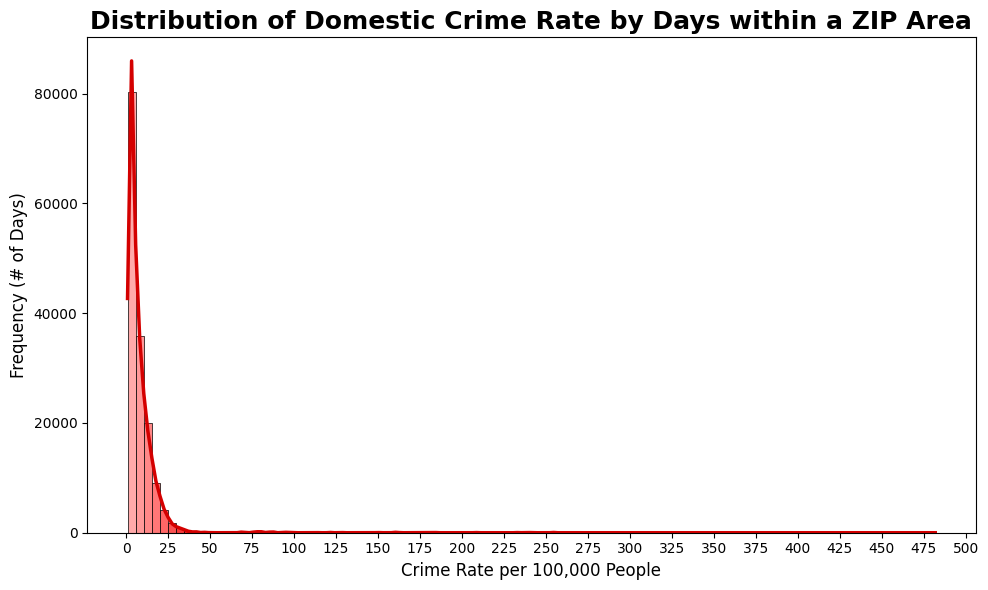

In [12]:
# Aggregate data to get one row per day per ZIP (to count days, not cases)
daily_crime_rates = DomWeatherCrimePlots_df.groupby(['Date', 'ZIP'])['DailyCrimeRateByZIP'].first().reset_index()

# Reverse the gradient colors
red_gradient = [
    '#ffaaaa', '#ff9999', '#ff8888', '#ff7777', '#ff6666',  # Lighter reds
    '#f95252', '#f73939', '#f52020', '#f30808', '#e70000',  # Mid-range reds
    '#d40000', '#c10000', '#b00000', '#a00000', '#900000',  # Darker reds
    '#880000', '#770000', '#660000', '#550000', '#440000'   # Deep dark reds
]

# Create the figure
plt.figure(figsize=(10, 6))

# Create histogram with KDE
ax = sns.histplot(daily_crime_rates['DailyCrimeRateByZIP'], bins=100, kde=True, edgecolor='black', alpha=0.9)

# Apply gradient colors to bars
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(red_gradient[i % len(red_gradient)])

# Adjust the KDE line to be bold and red
for line in ax.lines:
    line.set_color('#d40000')  # Fitting deep red KDE color
    line.set_linewidth(2.5)  # Make the KDE line thicker for visibility

# Add title and labels
plt.title('Distribution of Domestic Crime Rate by Days within a ZIP Area', fontsize=18, fontweight='bold')
plt.xlabel('Crime Rate per 100,000 People', fontsize=12)
plt.ylabel('Frequency (# of Days)', fontsize=12)

# Set x-axis ticks to increment by 25
max_crime_rate = daily_crime_rates['DailyCrimeRateByZIP'].max()
plt.xticks(range(0, int(max_crime_rate) + 25, 25))

# Adjust layout
plt.tight_layout()
plt.show()

**Figure 1**

This histogram shows the number of days with certain domestic crime rates across Chicago ZIP code areas. The x-axis represents daily domestic crime rates per 100,000 people, and the y-axis shows the frequency of days with those rates. The distribution is right-skewed, with over 80,000 days having a crime rate between 0 and 5 (per 100,000 people). The long tail extends to extremely high rates, with some days reaching up to 490, likely due to low-population ZIP areas experiencing high crime counts. This visualization provides a baseline for understanding domestic crime frequency.

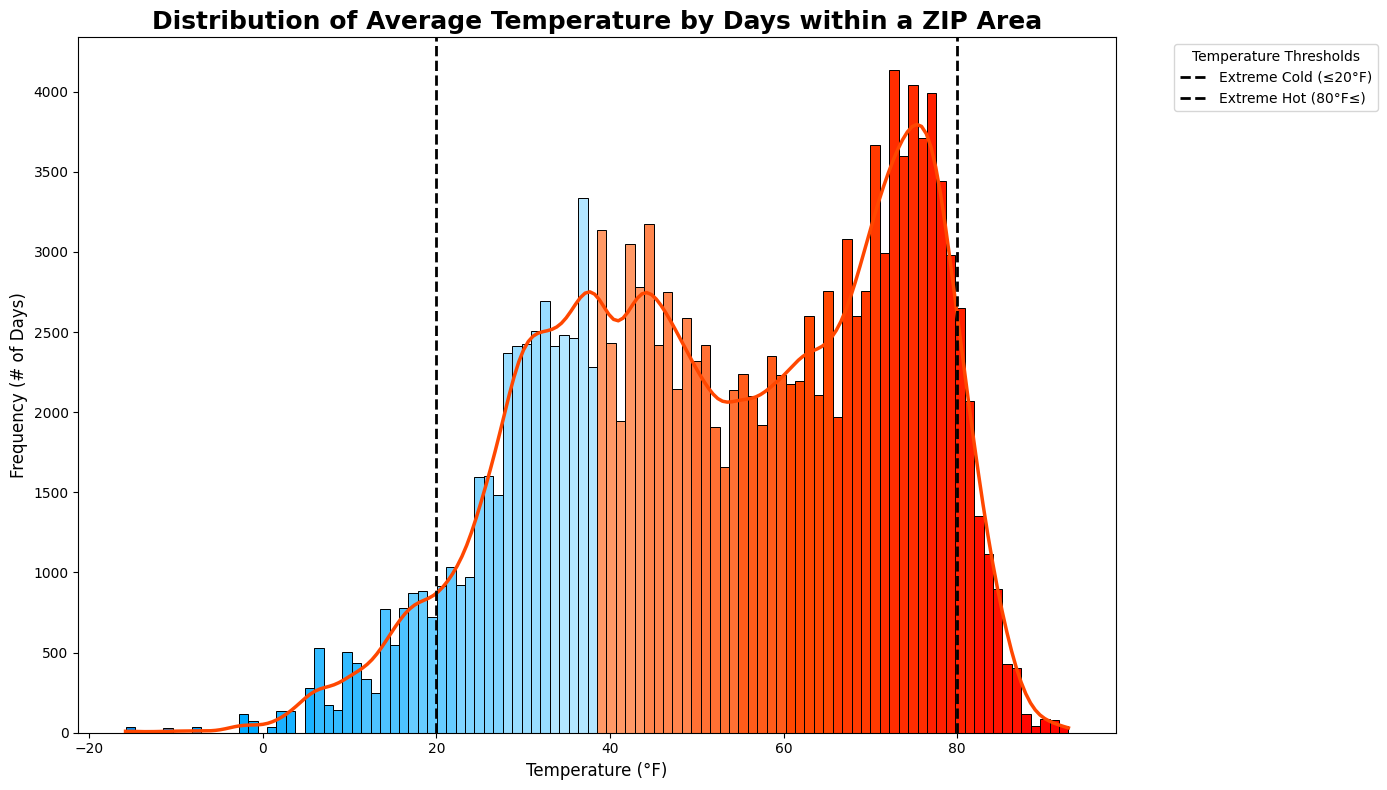

In [13]:
# Aggregate data to get one row per day per ZIP (to count days, not cases)
daily_avg_temps = DomWeatherCrimePlots_df.groupby(['Date', 'ZIP'])['AvgTemp(°F)'].first().reset_index()

# Define gradient colors for cold (light blue) to hot (red-orange)
temp_gradient = [
    '#0088ee', '#0099f7', '#00aaff', '#1ab2ff','#33bbff', # Mid-range blues
    '#4dc3ff', '#66ccff', '#80d4ff', '#99ddff', '#b3e6ff',  # Light blue (cold) 
    '#ff9966', '#ff854d', '#ff7033', '#ff5c1a', '#ff4700',  # Warm transition
    '#ff3a00', '#ff2d00', '#ff2000', '#ff1300', '#ff0600'   # Hot red-orange
]

# Create figure
plt.figure(figsize=(14, 8))

# Create histogram with KDE
ax = sns.histplot(daily_avg_temps['AvgTemp(°F)'], bins=100, kde=True, edgecolor='black', alpha=0.9)

# Apply gradient colors to bars, changing every 20 rectangles
for i, patch in enumerate(ax.patches):
    color_index = (i // 5) % len(temp_gradient)  # Change color every 20 rectangles
    patch.set_facecolor(temp_gradient[color_index])

# Adjust the KDE line to be bold and match the theme
for line in ax.lines:
    line.set_color('#ff4700')  # Deep red-orange KDE for heat effect
    line.set_linewidth(2.5)  # Make the KDE line thicker for visibility

# Add vertical lines for extreme cold and hot days
plt.axvline(x=20, color='black', linestyle='--', linewidth=2, label='Extreme Cold (≤20°F)')
plt.axvline(x=80, color='black', linestyle='--', linewidth=2, label='Extreme Hot (80°F≤)')

# Add title and labels
plt.title('Distribution of Average Temperature by Days within a ZIP Area', fontsize=18, fontweight='bold')
plt.xlabel('Temperature (°F)', fontsize=12)
plt.ylabel('Frequency (# of Days)', fontsize=12)

# Add legend
plt.legend(title='Temperature Thresholds', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

**Figure 2**

This histogram shows the number of days with certain average temperatures across Chicago ZIP code areas. The x-axis represents temperature in Fahrenheit, and the y-axis shows the frequency of days with those temperatures. The distribution is left-skewed, peaking at 75°F, with extreme temperature days (below 20°F or above 80°F) being less common. This highlights moderate temperatures as the norm, with extreme temperatures occurring less frequently.

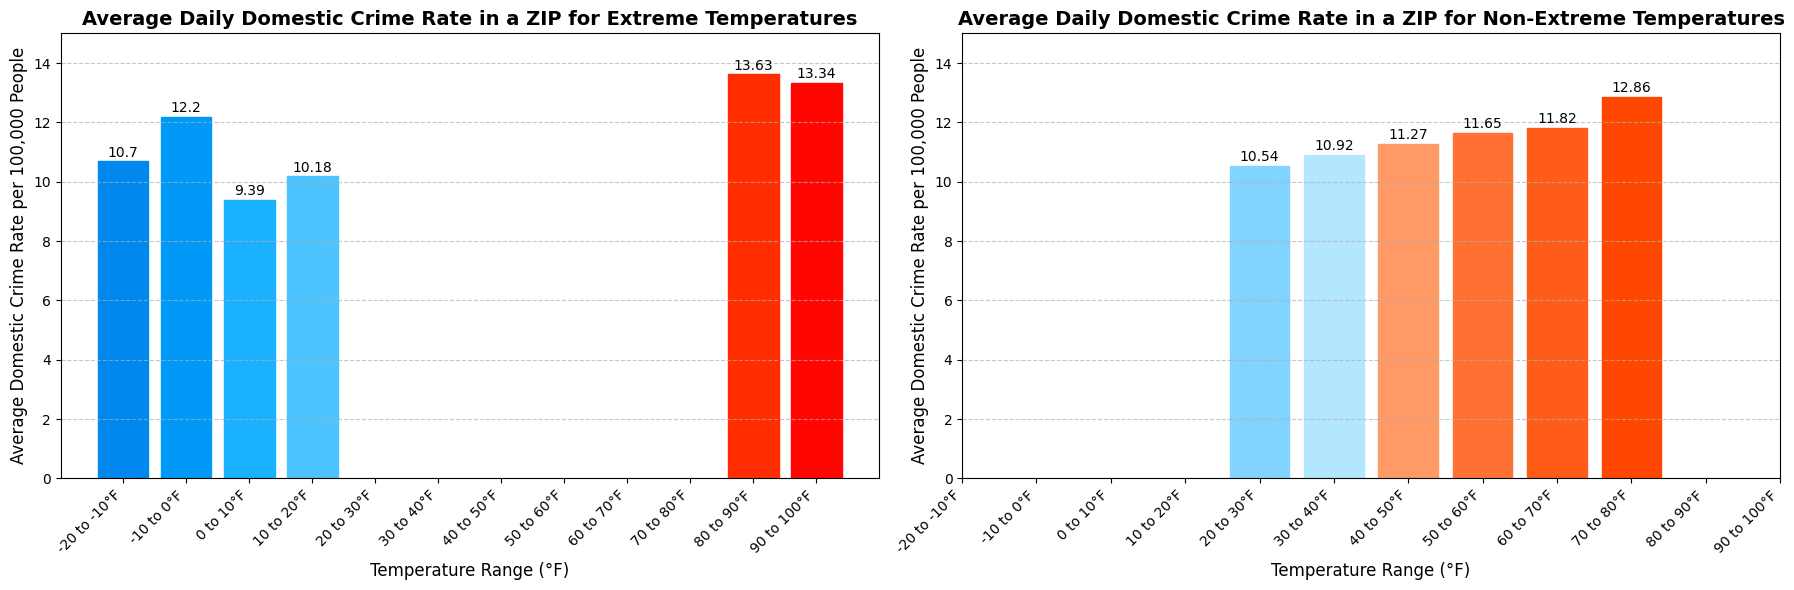

In [14]:
# Define temperature bins (from -20 to 100 in increments of 10)
bins = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Adjusted temperature bins
labels = ['-20 to -10°F', '-10 to 0°F', '0 to 10°F', '10 to 20°F', '20 to 30°F', '30 to 40°F', '40 to 50°F', 
          '50 to 60°F', '60 to 70°F', '70 to 80°F', '80 to 90°F', '90 to 100°F']

# Define a gradient color scale from cold (light blue) to hot (red-orange)
temp_gradient = [
    '#0088ee', 
    '#0099f7',  
    '#1ab2ff',  
    '#4dc3ff', 
    '#80d4ff', 
    '#b3e6ff',  
    '#ff9966',
    '#ff7033',  
    '#ff5c1a',  
    '#ff4700',  
    '#ff2d00',  
    '#ff0600'   
]

# Function to plot a bar chart
def plot_bar_chart(df, title, ax, is_extreme=False):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Create a new column for temperature bins
    df['TempBin'] = pd.cut(df['AvgTemp(°F)'], bins=bins, labels=labels, right=False)
    
    # Filter bins for extreme temperatures (if applicable)
    if is_extreme:
        df = df[df['TempBin'].isin(['-20 to -10°F', '-10 to 0°F', '0 to 10°F', '10 to 20°F', '80 to 90°F', '90 to 100°F'])]
    
    # Group by temperature bins and calculate the average crime rate for each bin
    avg_crime_rate_by_temp = df.groupby('TempBin', observed=False)['DailyCrimeRateByZIP'].mean()
    
    # Plot the bar chart
    bars = ax.bar(avg_crime_rate_by_temp.index, avg_crime_rate_by_temp, edgecolor='black')
    
    # Apply gradient colors to bars
    for i, bar in enumerate(bars):
        bar.set_color(temp_gradient[i % len(temp_gradient)])
    
    # Add value labels on top of the bars
    for i, value in enumerate(avg_crime_rate_by_temp):
        ax.text(i, value + 0.05, round(value, 2), ha='center', va='bottom', fontsize=10, color='black')
    
    # Set the title and labels
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Temperature Range (°F)", fontsize=12)
    ax.set_ylabel("Average Domestic Crime Rate per 100,000 People", fontsize=12)
    
    # Rotate x-axis labels to make them readable
    ax.set_xticks(range(len(avg_crime_rate_by_temp.index)))
    ax.set_xticklabels(avg_crime_rate_by_temp.index, rotation=45, ha='right')

    # Set y-axis limit
    ax.set_ylim(0, 15)
    
    # Add gridlines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot for extreme_hot_cold_df (filtered bins)
plot_bar_chart(extreme_hot_cold_df, "Average Daily Domestic Crime Rate in a ZIP for Extreme Temperatures", ax1, is_extreme=True)

# Plot for non_extreme_df
plot_bar_chart(non_extreme_df, "Average Daily Domestic Crime Rate in a ZIP for Non-Extreme Temperatures", ax2)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Figure 3** 

This bar chart shows the average daily domestic crime rate across ZIP areas within different temperature ranges. Cold days have on average an overall lower rate, while hot days have increasingly higher rates. For non-extreme temperatures, crime rates steadily increase with temperature, suggesting heat exacerbates domestic crime due to indoor confinement and agitation, while cold reduces it.

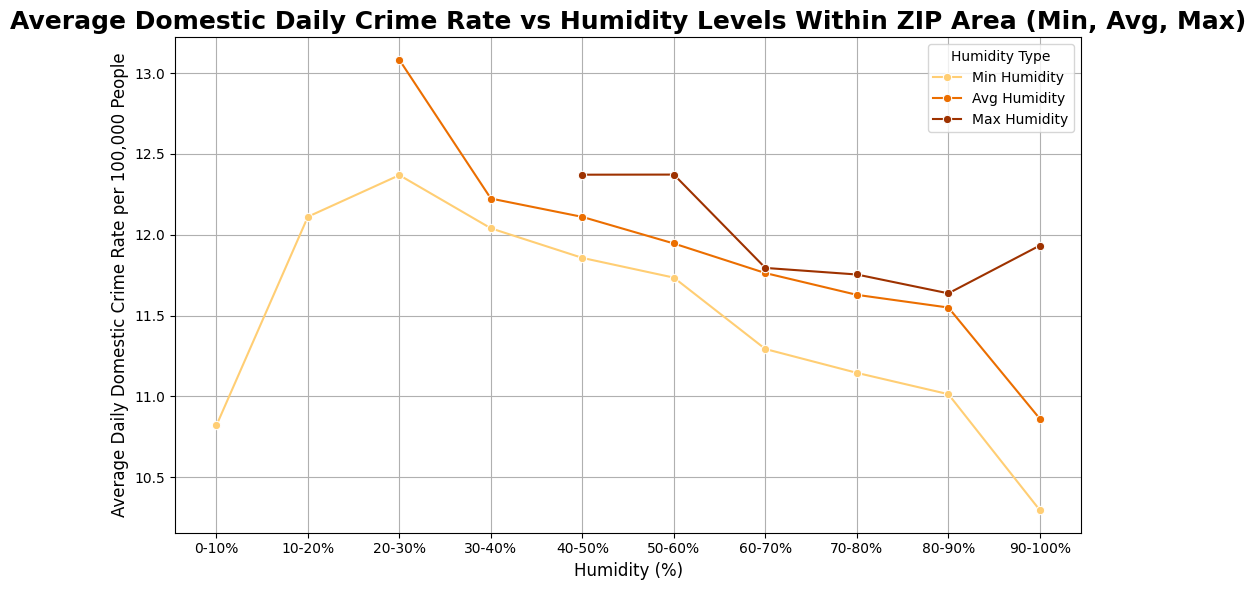

In [15]:
# Define the humidity bins (adjust as needed)
humidity_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
humidity_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Create binned columns for Min, Avg, and Max Humidity
DomWeatherCrimePlots_df['MinHumidityBin'] = pd.cut(DomWeatherCrimePlots_df['MinHumidity(%)'], bins=humidity_bins, labels=humidity_labels, right=False)
DomWeatherCrimePlots_df['AvgHumidityBin'] = pd.cut(DomWeatherCrimePlots_df['AvgHumidity(%)'], bins=humidity_bins, labels=humidity_labels, right=False)
DomWeatherCrimePlots_df['MaxHumidityBin'] = pd.cut(DomWeatherCrimePlots_df['MaxHumidity(%)'], bins=humidity_bins, labels=humidity_labels, right=False)

# Calculate the average crime rate per humidity bin for Min, Avg, and Max Humidity
avg_crime_rate_min_humidity = DomWeatherCrimePlots_df.groupby('MinHumidityBin', observed=False)['DailyCrimeRateByZIP'].mean().reset_index()
avg_crime_rate_avg_humidity = DomWeatherCrimePlots_df.groupby('AvgHumidityBin', observed=False)['DailyCrimeRateByZIP'].mean().reset_index()
avg_crime_rate_max_humidity = DomWeatherCrimePlots_df.groupby('MaxHumidityBin', observed=False)['DailyCrimeRateByZIP'].mean().reset_index()

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Plot the binned data
sns.lineplot(x='MinHumidityBin', y='DailyCrimeRateByZIP', data=avg_crime_rate_min_humidity, label='Min Humidity', color='#ffce74', marker='o')
sns.lineplot(x='AvgHumidityBin', y='DailyCrimeRateByZIP', data=avg_crime_rate_avg_humidity, label='Avg Humidity', color='#eb6e00', marker='o')
sns.lineplot(x='MaxHumidityBin', y='DailyCrimeRateByZIP', data=avg_crime_rate_max_humidity, label='Max Humidity', color='#9e3200', marker='o')

# Set titles and labels
plt.title("Average Domestic Daily Crime Rate vs Humidity Levels Within ZIP Area (Min, Avg, Max)", fontsize=18, fontweight='bold')
plt.xlabel("Humidity (%)", fontsize=12)
plt.ylabel("Average Daily Domestic Crime Rate per 100,000 People", fontsize=12)
plt.legend(title="Humidity Type")

# Show grid and layout
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

**Figure 4**

This line plot examines the relationship between humidity and domestic crime rates. Crime rates peak at 20-30% humidity and decline as humidity increases, suggesting high humidity suppresses crime due to physical discomfort and exhaustion.

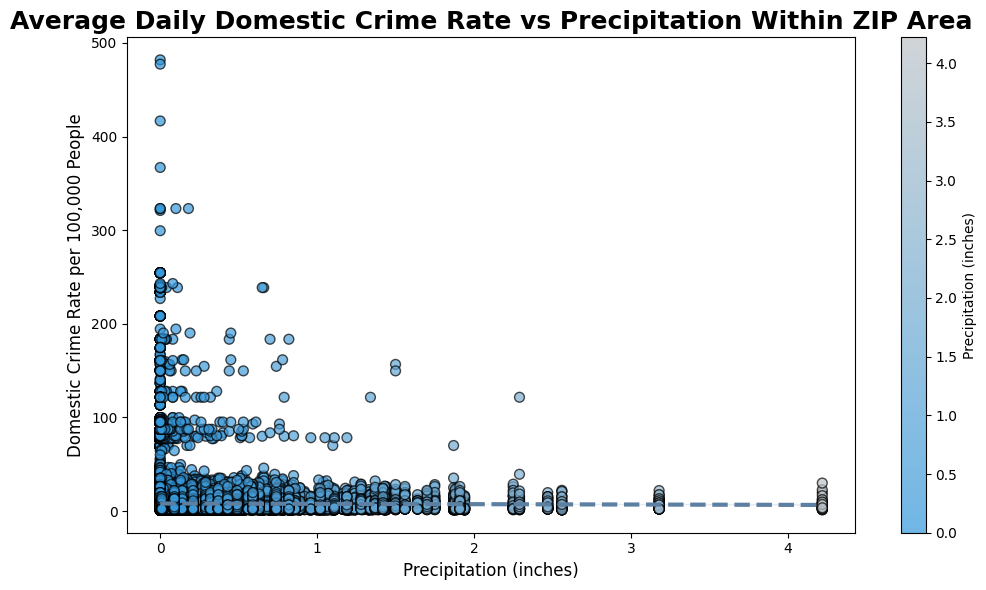

In [16]:
# Aggregate data to get one row per day per ZIP (to count days, not cases)
daily_precipitation = DomWeatherCrimePlots_df.groupby(['Date', 'ZIP'])['TotalPrecipitation(in)'].first().reset_index()
daily_crime_rates = DomWeatherCrimePlots_df.groupby(['Date', 'ZIP'])['DailyCrimeRateByZIP'].first().reset_index()

# Merge the aggregated data
daily_data = daily_precipitation.merge(daily_crime_rates, on=['Date', 'ZIP'], how='left')

# Create the figure
plt.figure(figsize=(10, 6))

# Create a custom colormap transitioning from blue to grey
custom_cmap = mcolors.LinearSegmentedColormap.from_list("blue_grey", ["#3498db", "#bdc3c7"])

# Scatter plot with custom colormap applied to precipitation values
scatter = plt.scatter(daily_data['TotalPrecipitation(in)'], daily_data['DailyCrimeRateByZIP'], 
                      c=daily_data['TotalPrecipitation(in)'], cmap=custom_cmap, alpha=0.7, s=50, edgecolor='black')

# Regression line with a subtle grey-blue color
sns.regplot(x=daily_data['TotalPrecipitation(in)'], y=daily_data['DailyCrimeRateByZIP'], 
            scatter=False, line_kws={'color': '#5d7fa1', 'lw': 3, 'linestyle': '--'})

# Add colorbar to show gradient transition
cbar = plt.colorbar(scatter)
cbar.set_label("Precipitation (inches)")

# Set the title and labels
plt.title("Average Daily Domestic Crime Rate vs Precipitation Within ZIP Area", fontsize=18, fontweight='bold')
plt.xlabel("Precipitation (inches)", fontsize=12)
plt.ylabel("Domestic Crime Rate per 100,000 People", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

**Figure 5**

This scatterplot explores the relationship between daily precipitation and domestic crime rates. Most data points cluster near 0 inches, with crime rates slightly decreasing as precipitation increases, contradicting the hypothesis that bad weather increases indoor crimes. However, sparse data points at higher precipitation levels could indicate underreporting during severe weather.

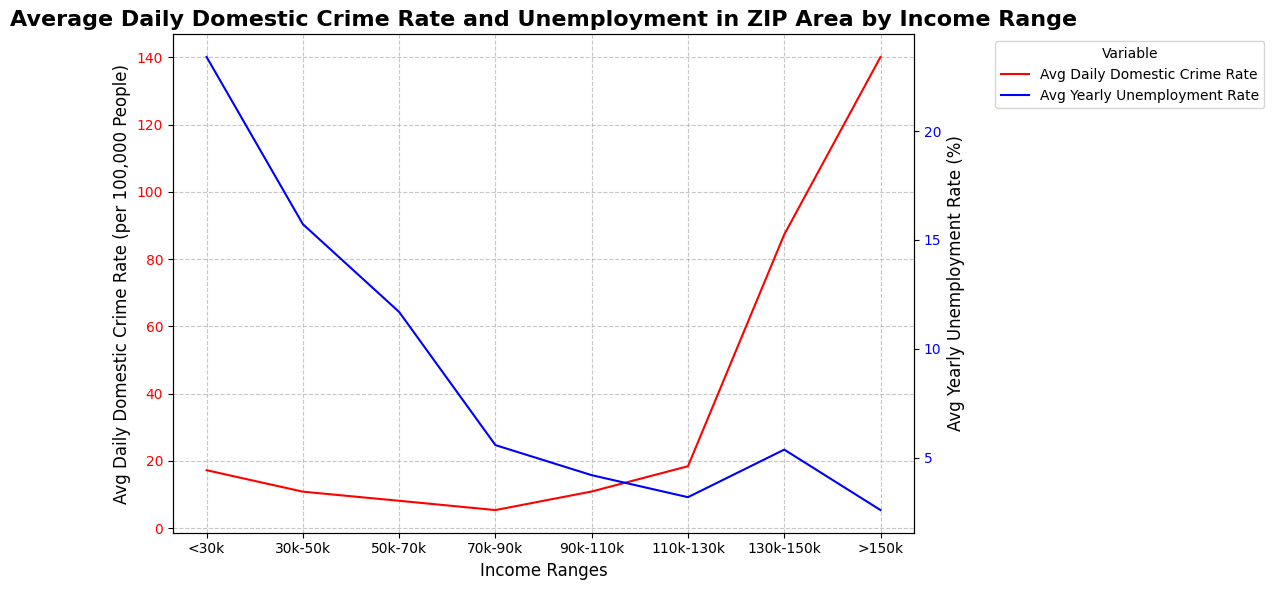

In [17]:
# Aggregate data to get one row per day per ZIP (to count days, not cases)
daily_crime = DomWeatherCrimePlots_df.groupby(['Date', 'ZIP'])['DailyCrimeRateByZIP'].first().reset_index()

# Merge daily crime data with the original DataFrame to include other variables
merged_data = pd.merge(DomWeatherCrimePlots_df, daily_crime, on=['Date', 'ZIP'], how='left', suffixes=('', '_daily'))

# Define bins for YearlyMedianIncomeByZIP
income_bins = [0, 30000, 50000, 70000, 90000, 110000, 130000, 150000, float('inf')]
income_labels = ['<30k', '30k-50k', '50k-70k', '70k-90k', '90k-110k', '110k-130k', '130k-150k', '>150k']

# Create a new column for income bins
merged_data['IncomeBin'] = pd.cut(merged_data['YearlyMedianIncomeByZIP'], bins=income_bins, labels=income_labels)

# Group by income bins and calculate the mean for unemployment and daily crime rate
grouped_data = merged_data.groupby('IncomeBin', observed=False)[['YearlyUnemploymentRateByZIP', 'DailyCrimeRateByZIP']].mean().reset_index()

# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot for DailyCrimeRateByZIP (left axis)
line1 = sns.lineplot(x='IncomeBin', y='DailyCrimeRateByZIP', data=grouped_data, color='red', ax=ax1, label='Avg Daily Domestic Crime Rate')
ax1.set_xlabel("Income Ranges", fontsize=12)
ax1.set_ylabel("Avg Daily Domestic Crime Rate (per 100,000 People)", fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(linestyle='--', alpha=0.7)

# Create a secondary axis
ax2 = ax1.twinx()

# Plot for YearlyUnemploymentRateByZIP (right axis)
line2 = sns.lineplot(x='IncomeBin', y='YearlyUnemploymentRateByZIP', data=grouped_data, color='blue', ax=ax2, label='Avg Yearly Unemployment Rate')
ax2.set_ylabel("Avg Yearly Unemployment Rate (%)", fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

# Add title
plt.title("Average Daily Domestic Crime Rate and Unemployment in ZIP Area by Income Range", fontsize=16, fontweight='bold')

# Remove individual legends
ax1.get_legend().remove()
ax2.get_legend().remove()

# Combine legends
lines = line1.get_lines() + line2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, title='Variable', bbox_to_anchor=(1.1, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Figure 6**

This line plot visualizes the relationship between median household income, domestic crime rates, and unemployment rates. Lower-income areas have higher unemployment, but higher domestic crime rates in high-income areas contradict our hypothesis, highlighting the need for interventions across all income levels.

# Project 2

## 2.1 The Message

### THE MESSAGE!: Extreme cold decreases domestic crime, while extreme heat increases domestic crime.


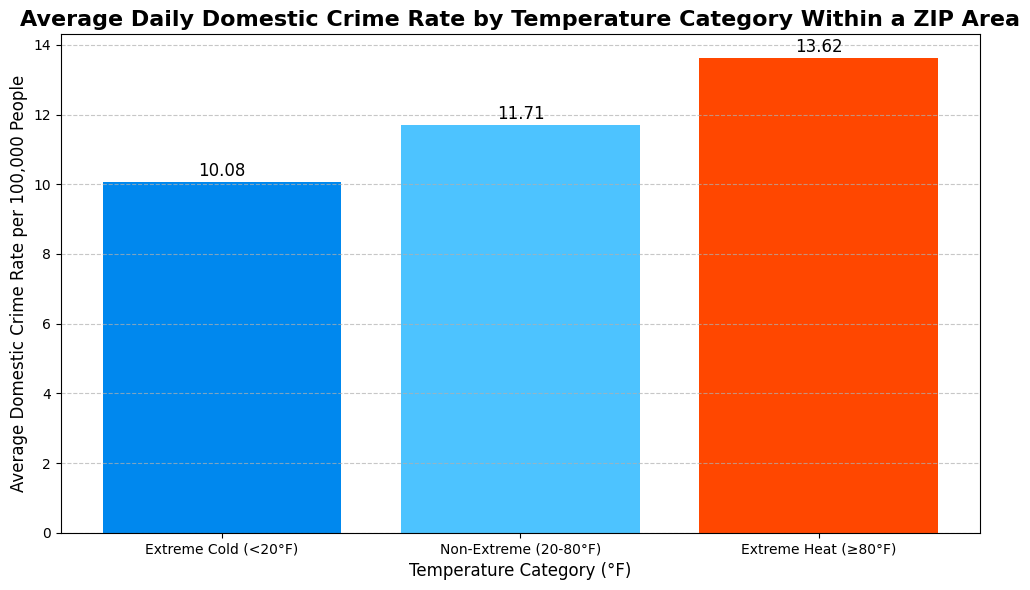

In [18]:
DomWeatherCrimeMessage_df = DomWeatherCrime_df.copy()

bins = [-20, 20, 80, 100]  # Extreme cold: <-20°F to <20°F, Non-extreme: 20°F to <80°F, Extreme heat: 80°F+
labels = ['Extreme Cold (<20°F)', 'Non-Extreme (20-80°F)', 'Extreme Heat (≥80°F)']

# Create a new column for temperature categories
DomWeatherCrime_df['TempCategory'] = pd.cut(DomWeatherCrime_df['AvgTemp(°F)'], bins=bins, labels=labels, right=False)

# Group by temperature categories and calculate the average crime rate for each
avg_crime_rate_by_temp = DomWeatherCrime_df.groupby('TempCategory', observed=False)['DailyCrimeRateByZIP'].mean()

# Define colors for each category
colors = ['#0088ee', '#4dc3ff', '#ff4700']  # Blue for cold, light blue for normal, red for heat

# Plot the bar chart
plt.figure(figsize=(10, 6))

bars = plt.bar(avg_crime_rate_by_temp.index, avg_crime_rate_by_temp, color=colors)

# Add value labels on top of the bars
for i, value in enumerate(avg_crime_rate_by_temp):
    plt.text(i, value + 0.05, round(value, 2), ha='center', va='bottom', fontsize=12, color='black')

# Set the title and labels
plt.title("Average Daily Domestic Crime Rate by Temperature Category Within a ZIP Area", fontsize=16, fontweight='bold')
plt.xlabel("Temperature Category (°F)", fontsize=12)
plt.ylabel("Average Domestic Crime Rate per 100,000 People", fontsize=12)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

**Main Message Plot**

This bar chart visualizes the main message, displaying the average daily domestic crime rate across temperature ranges from -20°F to 100°F. A gradient color scheme represents the transition from cold to hot temperatures, with vertical dashed lines marking extreme cold (<20°F) and extreme heat (≥80°F). The plot shows crime rates are on average lower in the coldest ranges and spike significantly in the hottest, supporting the conclusion that extreme cold decreases domestic crime, while extreme heat increases it.

## 2.2 Maps and Interpretations

In [19]:
DomWeatherCrimeMaps_df = DomWeatherCrime_df.copy()

In [20]:
# Convert crime data into a GeoDataFrame
DomWeatherCrimeMaps_df["Coordinates"] = DomWeatherCrimeMaps_df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
crime_gdf = gpd.GeoDataFrame(DomWeatherCrimeMaps_df, geometry="Coordinates", crs="EPSG:4326")

# Load the Chicago boundary shapefile
chicago_shapefile_df = pd.read_csv('Chicago_Shapefile.csv')
chicago_shapefile_df['geometry'] = gpd.GeoSeries.from_wkt(chicago_shapefile_df['the_geom'])
chicago_gdf = gpd.GeoDataFrame(chicago_shapefile_df, geometry='geometry', crs="EPSG:4326")

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_crime_map(crime_df, title):
    # Aggregate AVERAGE DailyCrimeRateByZIP
    crime_summary = crime_df.groupby('ZIP')['DailyCrimeRateByZIP'].mean().reset_index(name='AvgDailyCrimeRateByZIP')
    
    # Merge crime data with ZIP boundaries
    zips_gdf_copy = zips_gdf.copy()  # Avoid modifying the original
    zips_gdf_copy['ZIP'] = zips_gdf_copy['ZIP'].astype(str)
    crime_summary['ZIP'] = crime_summary['ZIP'].astype(str)
    zips_gdf_copy = zips_gdf_copy.merge(crime_summary, on='ZIP', how='left')
    zips_gdf_copy['AvgDailyCrimeRateByZIP'].fillna(0, inplace=True)  # Replace NaN with 0

    # Separate ZIP codes into two groups: ≤30 and >30
    low_crime = zips_gdf_copy[zips_gdf_copy['AvgDailyCrimeRateByZIP'] <= 30]
    high_crime = zips_gdf_copy[zips_gdf_copy['AvgDailyCrimeRateByZIP'] > 30]

    # Plot the data
    fig, ax = plt.subplots(figsize=(14, 12))  # Increased size to prevent legend cutoff

    # Plot Chicago boundary
    chicago_gdf.plot(ax=ax, edgecolor='black', color='white', alpha=0.5)

    # Plot low crime ZIP codes (<= 30) in "Blues"
    low_crime_plot = low_crime.plot(
        ax=ax, column='AvgDailyCrimeRateByZIP', cmap='Blues', 
        edgecolor='black', linewidth=1.5, vmin=0, vmax=30,
        legend=True, legend_kwds={'label': "Domestic Crime Rate ≤ 30", 'orientation': "vertical", 'shrink': 0.5}
    )

    # Plot high crime ZIP codes (> 30) in "Reds"
    high_crime_plot = high_crime.plot(
        ax=ax, column='AvgDailyCrimeRateByZIP', cmap='rocket', 
        edgecolor='black', linewidth=1.5, vmin=30, vmax=high_crime['AvgDailyCrimeRateByZIP'].max(),
        legend=True, legend_kwds={'label': "Domestic Crime Rate > 30", 'orientation': "vertical", 'shrink': 0.5}
    )

    # Adjust map limits for Chicago
    ax.set_xlim([-87.97, -87.5])  # Longitude bounds for Chicago
    ax.set_ylim([41.63, 42.04])    # Latitude bounds for Chicago

    # Add title and labels
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    plt.show()


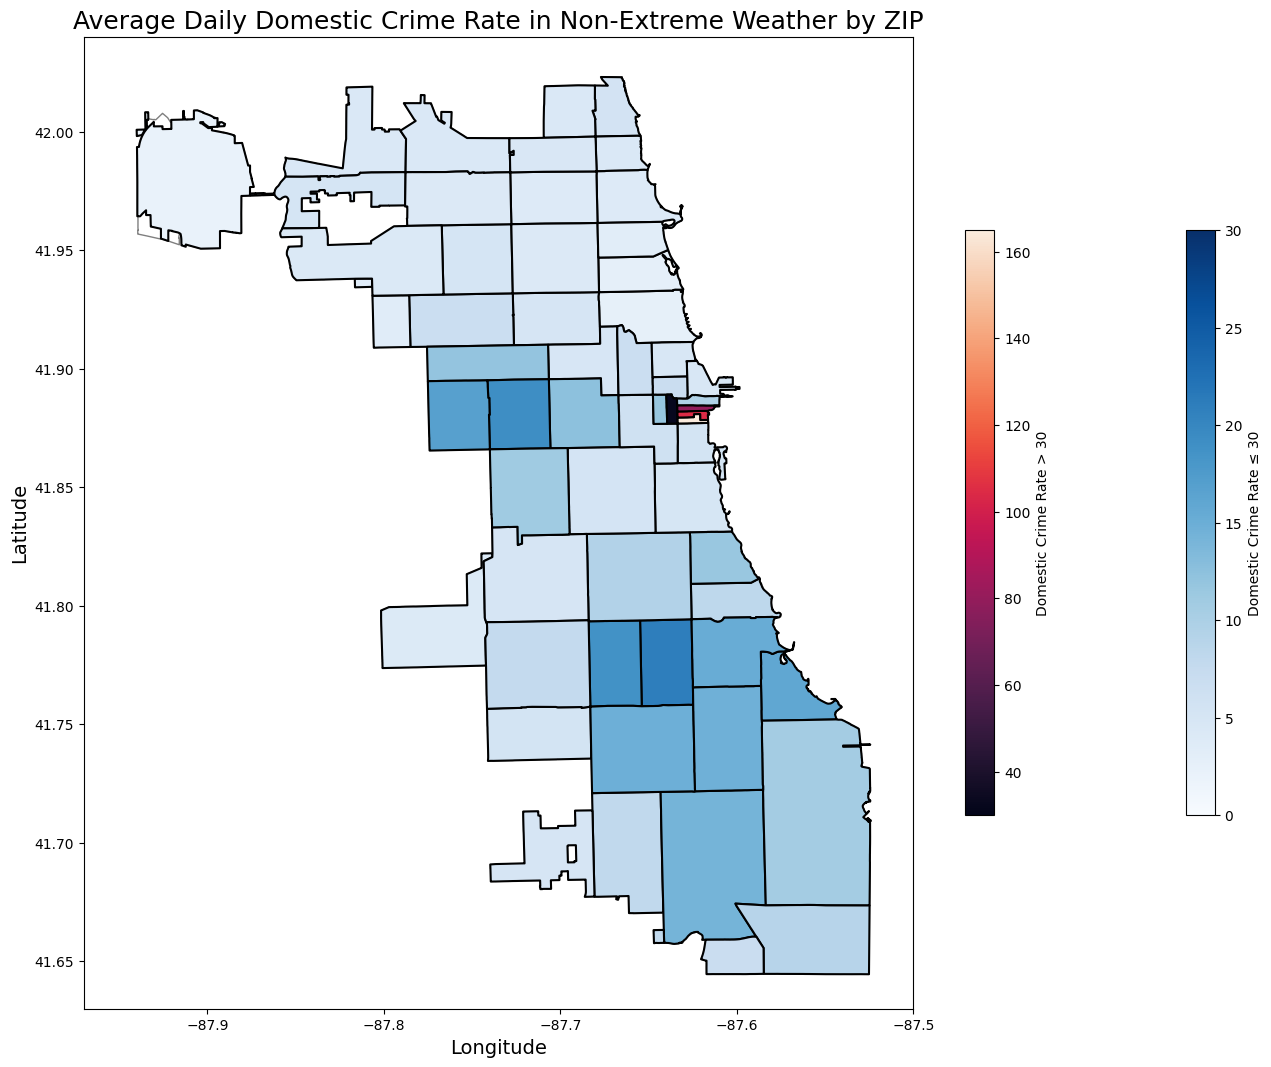

In [22]:
plot_crime_map(non_extreme_df, "Average Daily Domestic Crime Rate in Non-Extreme Weather by ZIP")

**Map Figure 1**

This map visualizes the average daily domestic crime rate by ZIP code in Chicago during non-extreme weather conditions (2010–2020), revealing spatial patterns and variations in crime distribution. As crime rates vary extremely, two legends with different colour schemes are implemented to better display domestic crime rate differences. Lower crime rates (≤30) are shown in shades of blue, while higher and outlier crime rates (>30) are highlighted in red, purple, and black, indicating hotspots of domestic violence. Since weather data is constant across Chicago daily, this map serves as a benchmark to compare how ZIP areas react to different weather conditions.

From the map, ZIP areas across Chicago have a daily domestic crime rate of about 5 to 25. An outlier location with an extremely high crime rate is visible, likely due to a high crime count relative to its population, potentially reflecting localized factors like economic distress or limited access to social services. Overall, the map provides a baseline for further analysis.

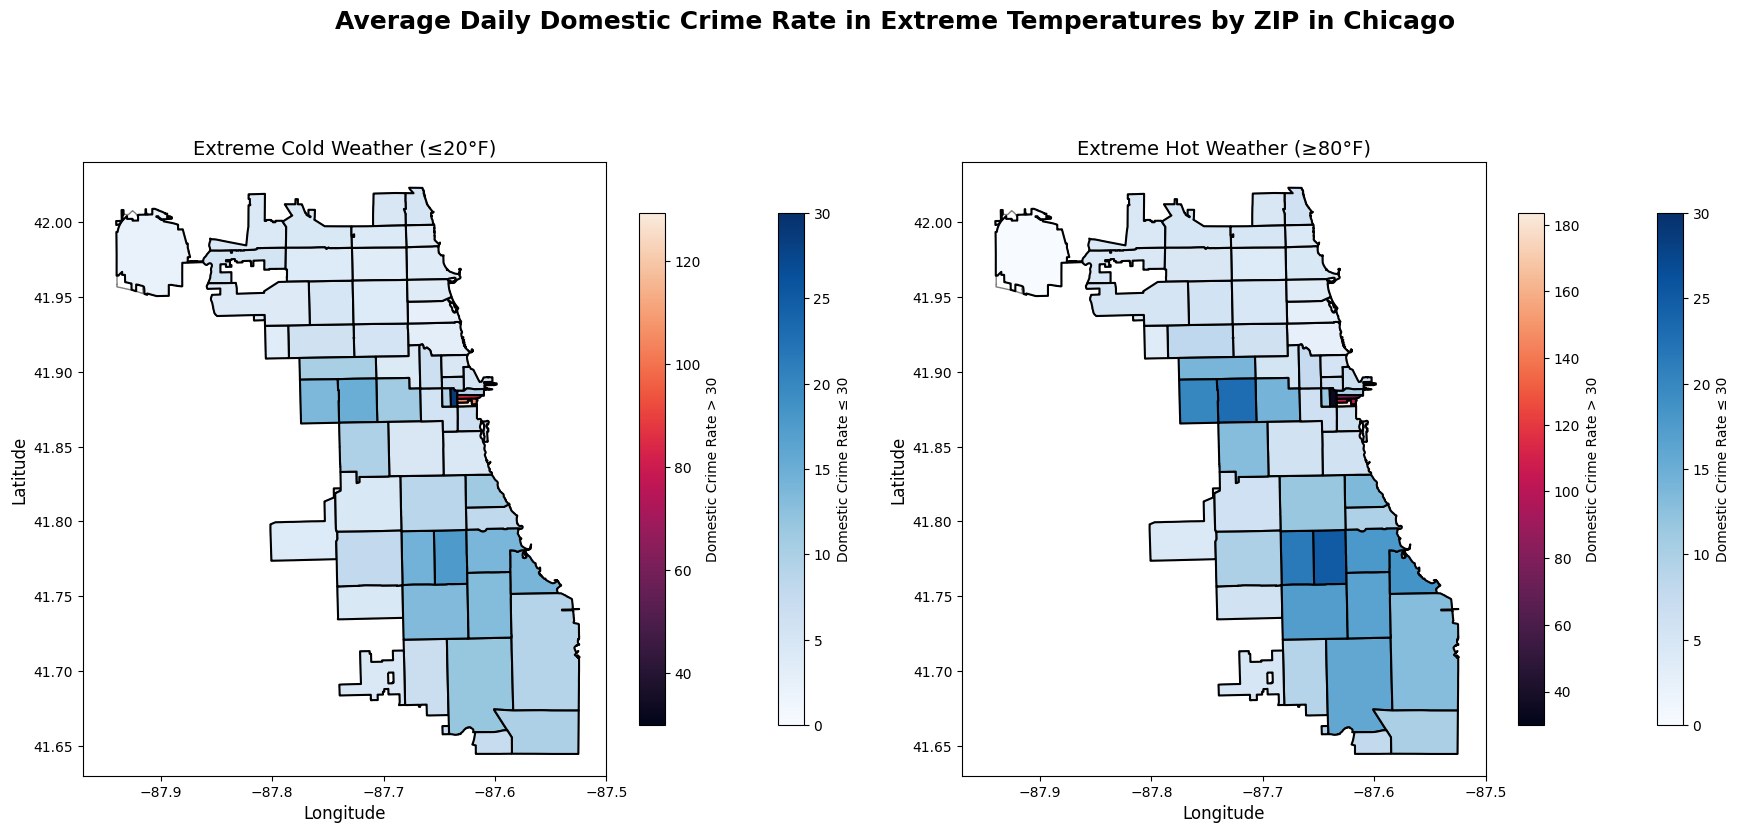

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_crime_maps(crime_df, title, ax):
    # Aggregate AVERAGE DailyCrimeRateByZIP
    crime_summary = crime_df.groupby('ZIP')['DailyCrimeRateByZIP'].mean().reset_index(name='AvgDailyCrimeRateByZIP')
    
    # Merge crime data with ZIP boundaries
    zips_gdf_copy = zips_gdf.copy()  # Avoid modifying the original
    zips_gdf_copy['ZIP'] = zips_gdf_copy['ZIP'].astype(str)
    crime_summary['ZIP'] = crime_summary['ZIP'].astype(str)
    zips_gdf_copy = zips_gdf_copy.merge(crime_summary, on='ZIP', how='left')
    zips_gdf_copy['AvgDailyCrimeRateByZIP'].fillna(0, inplace=True)  # Replace NaN with 0

    # Separate ZIP codes into two groups: ≤30 and >30
    low_crime = zips_gdf_copy[zips_gdf_copy['AvgDailyCrimeRateByZIP'] <= 30]
    high_crime = zips_gdf_copy[zips_gdf_copy['AvgDailyCrimeRateByZIP'] > 30]

    # Plot Chicago boundary
    chicago_gdf.plot(ax=ax, edgecolor='black', color='white', alpha=0.5)

    # Plot low crime ZIP codes (<= 30) in "Blues"
    low_crime.plot(
        ax=ax, column='AvgDailyCrimeRateByZIP', cmap='Blues', 
        edgecolor='black', linewidth=1.5, vmin=0, vmax=30,
        legend=True, legend_kwds={'label': "Domestic Crime Rate ≤ 30", 'orientation': "vertical", 'shrink': 0.7}
    )

    # Plot high crime ZIP codes (> 30) in "Reds"
    high_crime.plot(
        ax=ax, column='AvgDailyCrimeRateByZIP', cmap='rocket', 
        edgecolor='black', linewidth=1.5, vmin=30, vmax=high_crime['AvgDailyCrimeRateByZIP'].max(),
        legend=True, legend_kwds={'label': "Domestic Crime Rate > 30", 'orientation': "vertical", 'shrink': 0.7}
    )

    # Adjust map limits for Chicago
    ax.set_xlim([-87.97, -87.5])  # Longitude bounds for Chicago
    ax.set_ylim([41.63, 42.04])    # Latitude bounds for Chicago

    # Add title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))  # Increased size for clarity

# Plot extreme_cold_df map on the left
plot_crime_maps(extreme_cold_df, "Extreme Cold Weather (≤20°F)", ax1)

# Plot extreme_hot_df map on the right
plot_crime_maps(extreme_hot_df, "Extreme Hot Weather (≥80°F)", ax2)

# Add a big header title at the center top
fig.suptitle("Average Daily Domestic Crime Rate in Extreme Temperatures by ZIP in Chicago", fontsize=18, fontweight='bold', y=1.05)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Map Figure 2**

These side-by-side maps compare average daily domestic crime rates in Chicago ZIP areas during extreme cold (≤20°F) and extreme heat (≥80°F) from 2010 to 2020, highlighting distinct spatial patterns.

Low-crime areas maintain similar rates regardless of weather. High-crime areas, however, are more affected by weather: crime rates decrease during extreme cold, likely due to reduced outdoor activity limiting conflict opportunities, contrary to the hypothesis that confinement increases violence. In contrast, crime rates rise during extreme heat, supporting the hypothesis that heat-induced agitation and irritability exacerbate domestic violence.

These patterns hold for outlier ZIP areas as well, where crime rates are higher in extreme heat and lower in extreme cold, though still significantly higher than other areas.

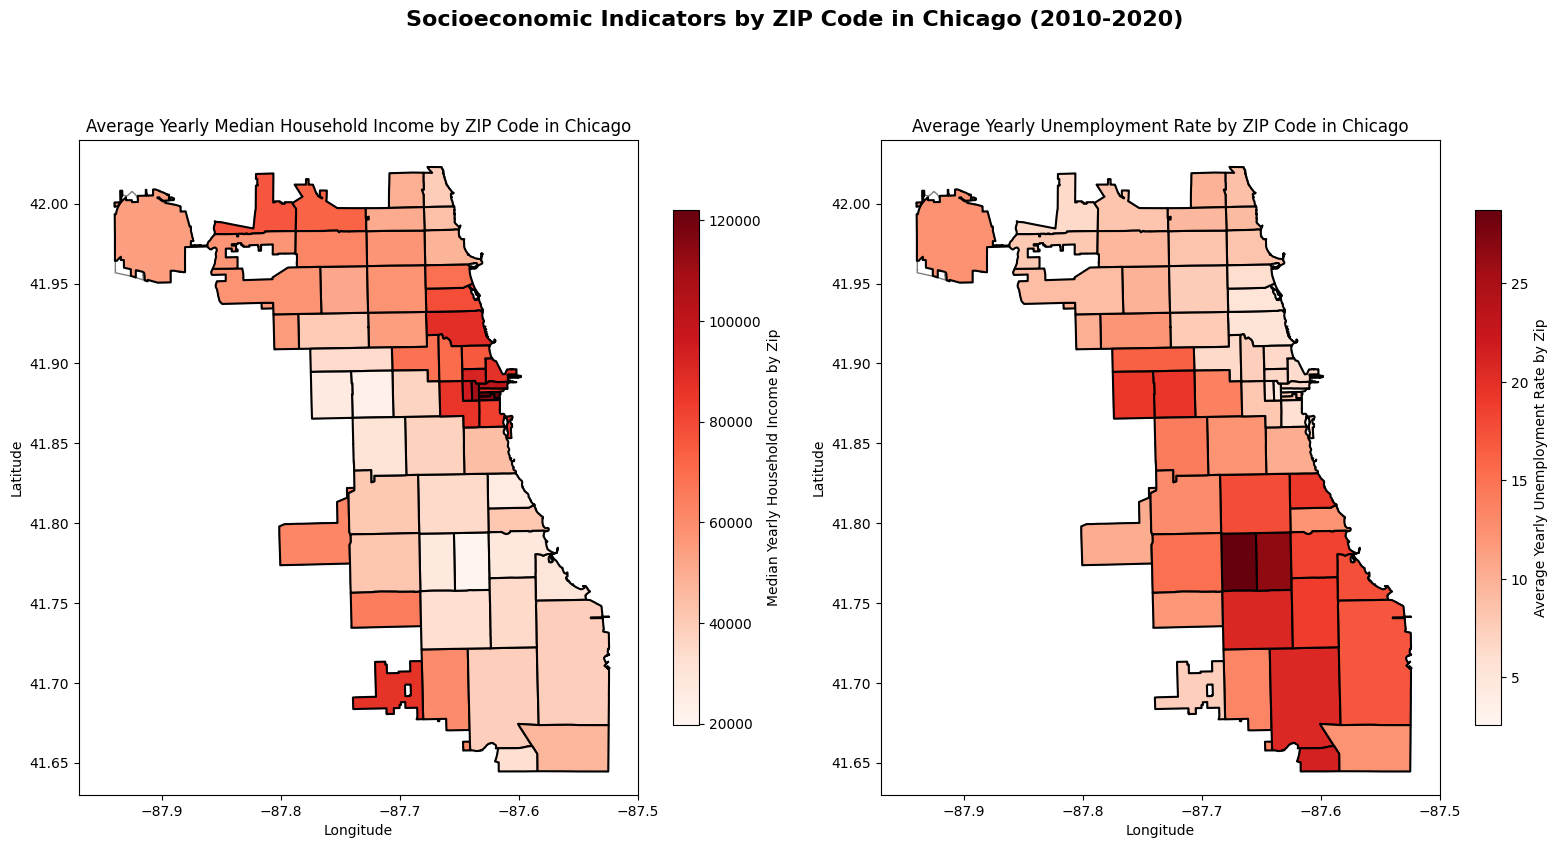

In [24]:
def plot_income_map(income_df, title, ax):
    # Aggregate MEDIAN YearlyMedianIncomeByZIP
    income_summary = income_df.groupby('ZIP')['YearlyMedianIncomeByZIP'].median().reset_index(name='MedianYearlyIncomeByZIP')
    
    # Merge income data with ZIP boundaries
    zips_gdf_copy = zips_gdf.copy()  # Avoid modifying the original
    zips_gdf_copy['ZIP'] = zips_gdf_copy['ZIP'].astype(str)
    income_summary['ZIP'] = income_summary['ZIP'].astype(str)
    zips_gdf_copy = zips_gdf_copy.merge(income_summary, on='ZIP', how='left')
    zips_gdf_copy['MedianYearlyIncomeByZIP'].fillna(0, inplace=True)  # Replace NaN with 0

    # Plot Chicago boundary
    chicago_gdf.plot(ax=ax, edgecolor='black', color='white', alpha=0.5)

    # Plot income data using a colormap
    zips_gdf_copy.plot(ax=ax, column='MedianYearlyIncomeByZIP', cmap='Reds', legend=True, 
                       legend_kwds={'label': "Median Yearly Household Income by Zip", 'orientation': "vertical", 'shrink': 0.7}, 
                       edgecolor='black', linewidth=1.5)

    # Adjust map limits for Chicago
    ax.set_xlim([-87.97, -87.5])  # Longitude bounds for Chicago
    ax.set_ylim([41.63, 42.04])    # Latitude bounds for Chicago

    # Add title and labels
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)

def plot_unemployment_map(unemployment_df, title, ax):
    # Aggregate MEDIAN YearlyUnemploymentRateByZIP
    unemployment_summary = unemployment_df.groupby('ZIP')['YearlyUnemploymentRateByZIP'].mean().reset_index(name='YearlyUnemploymentRateByZIP')
    
    # Merge unemployment data with ZIP boundaries
    zips_gdf_copy = zips_gdf.copy()  # Avoid modifying the original
    zips_gdf_copy['ZIP'] = zips_gdf_copy['ZIP'].astype(str)
    unemployment_summary['ZIP'] = unemployment_summary['ZIP'].astype(str)
    zips_gdf_copy = zips_gdf_copy.merge(unemployment_summary, on='ZIP', how='left')
    zips_gdf_copy['YearlyUnemploymentRateByZIP'].fillna(0, inplace=True)  # Replace NaN with 0

    # Plot Chicago boundary
    chicago_gdf.plot(ax=ax, edgecolor='black', color='white', alpha=0.5)

    # Plot unemployment data using a colormap
    zips_gdf_copy.plot(ax=ax, column='YearlyUnemploymentRateByZIP', cmap='Reds', legend=True,
                       legend_kwds={'label': "Average Yearly Unemployment Rate by Zip", 'orientation': "vertical", 'shrink': 0.7},
                       edgecolor='black', linewidth=1.5)

    # Adjust map limits for Chicago
    ax.set_xlim([-87.97, -87.5])  # Longitude bounds for Chicago
    ax.set_ylim([41.63, 42.04])    # Latitude bounds for Chicago

    # Add title and labels
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot income map on the left
plot_income_map(DomWeatherCrimeMaps_df, "Average Yearly Median Household Income by ZIP Code in Chicago", ax1)

# Plot unemployment map on the right
plot_unemployment_map(DomWeatherCrimeMaps_df, "Average Yearly Unemployment Rate by ZIP Code in Chicago", ax2)

# Add a big header title at the center top
fig.suptitle("Socioeconomic Indicators by ZIP Code in Chicago (2010-2020)", fontsize=16, fontweight='bold', y=1.05)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Map Figure 3**

These maps display median household income and unemployment rates across Chicago ZIP codes (2010–2020).

Higher-income areas (darker red) are concentrated in northern and central-east neighborhoods, while lower-income areas dominate the south and west. Low-income areas generally align with higher crime rates, supporting the hypothesis that poverty and limited resources during extreme weather increase vulnerability to domestic violence. However, a high-crime outlier with the highest household income suggests other factors, such as stress from high-pressure environments, may contribute to domestic violence.

Higher unemployment rates (darker red) are prevalent in lower-income areas, particularly in the south and west, reinforcing the link between economic vulnerability and crime. Yet, the high-crime outlier shows low unemployment, complicating this relationship.

These maps show that economic inequality heightens vulnerability to weather-induced domestic violence but also reveal domestic crime occurs across all income levels.

## 2.3 Regressions

In [25]:
# Copy the original DataFrame
DomWeatherCrimeRegressions_df = DomWeatherCrime_df.copy()

# Transform YearlyMedianIncomeByZIP to thousands
DomWeatherCrimeRegressions_df["YearlyMedianIncomeByZIP(thousands)"] = DomWeatherCrimeRegressions_df["YearlyMedianIncomeByZIP"] / 1000

# Create extreme temperature dummies
DomWeatherCrimeRegressions_df["Extreme_Cold"] = np.where(DomWeatherCrimeRegressions_df["AvgTemp(°F)"] <= 20, 1, 0)
DomWeatherCrimeRegressions_df["Extreme_Hot"] = np.where(DomWeatherCrimeRegressions_df["AvgTemp(°F)"] >= 80, 1, 0)

# Create interaction terms with extreme weather
DomWeatherCrimeRegressions_df["Extreme_Cold:YearlyMedianIncomeByZIP(thousands)"] = DomWeatherCrimeRegressions_df["Extreme_Cold"] * DomWeatherCrimeRegressions_df["YearlyMedianIncomeByZIP(thousands)"]
DomWeatherCrimeRegressions_df["Extreme_Hot:YearlyMedianIncomeByZIP(thousands)"] = DomWeatherCrimeRegressions_df["Extreme_Hot"] * DomWeatherCrimeRegressions_df["YearlyMedianIncomeByZIP(thousands)"]
DomWeatherCrimeRegressions_df["Extreme_Cold:YearlyUnemploymentRateByZIP"] = DomWeatherCrimeRegressions_df["Extreme_Cold"] * DomWeatherCrimeRegressions_df["YearlyUnemploymentRateByZIP"]
DomWeatherCrimeRegressions_df["Extreme_Hot:YearlyUnemploymentRateByZIP"] = DomWeatherCrimeRegressions_df["Extreme_Hot"] * DomWeatherCrimeRegressions_df["YearlyUnemploymentRateByZIP"]

In [26]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML

# Define the dependent variable
y = DomWeatherCrimeRegressions_df["DailyCrimeRateByZIP"]

# Define explanatory variables for 8 models
X1 = sm.add_constant(DomWeatherCrimeRegressions_df[["Extreme_Cold", "Extreme_Hot"]])  # Baseline extreme weather
X2 = sm.add_constant(DomWeatherCrimeRegressions_df[["Extreme_Cold", "Extreme_Hot", "MaxWindSpeed(mph)", "TotalPrecipitation(in)"]])  # Extreme weather + other weather
X3 = sm.add_constant(DomWeatherCrimeRegressions_df[["Extreme_Cold", "Extreme_Hot", "YearlyMedianIncomeByZIP(thousands)", "YearlyUnemploymentRateByZIP"]])  # Extreme weather + socioeconomic
X4 = sm.add_constant(DomWeatherCrimeRegressions_df[["Extreme_Cold", "Extreme_Hot", "AvgHumidity(%)"]])  # Extreme weather + humidity
X5 = sm.add_constant(DomWeatherCrimeRegressions_df[["Extreme_Cold", "Extreme_Hot", "MaxWindSpeed(mph)", "TotalPrecipitation(in)", "AvgHumidity(%)", "YearlyMedianIncomeByZIP(thousands)", "YearlyUnemploymentRateByZIP"]])  # Full model
X6 = sm.add_constant(DomWeatherCrimeRegressions_df[["Extreme_Cold", "Extreme_Hot", "AvgHumidity(%)", "YearlyMedianIncomeByZIP(thousands)", "YearlyUnemploymentRateByZIP", 
                                                   "Extreme_Cold:YearlyMedianIncomeByZIP(thousands)", "Extreme_Hot:YearlyMedianIncomeByZIP(thousands)",
                                                   "Extreme_Cold:YearlyUnemploymentRateByZIP", "Extreme_Hot:YearlyUnemploymentRateByZIP"]])  # Interaction effects
X7 = sm.add_constant(DomWeatherCrimeRegressions_df[["AvgTemp(°F)", "Extreme_Cold", "Extreme_Hot"]])  # AvgTemp with extreme weather
X8 = sm.add_constant(DomWeatherCrimeRegressions_df[["AvgTemp(°F)", "Extreme_Cold", "Extreme_Hot", "MaxWindSpeed(mph)", "TotalPrecipitation(in)", "AvgHumidity(%)", 
                                                   "YearlyMedianIncomeByZIP(thousands)", "YearlyUnemploymentRateByZIP"]])  # Comprehensive model

# Run OLS regressions
model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()
model4 = sm.OLS(y, X4).fit()
model5 = sm.OLS(y, X5).fit()
model6 = sm.OLS(y, X6).fit()
model7 = sm.OLS(y, X7).fit()
model8 = sm.OLS(y, X8).fit()

# Define variable orders for tables
variable_order_table1 = [
    "const",  # Intercept
    "Extreme_Cold",
    "Extreme_Hot",
    "MaxWindSpeed(mph)",
    "TotalPrecipitation(in)",
    "YearlyMedianIncomeByZIP(thousands)",
    "YearlyUnemploymentRateByZIP",
]

variable_order_table2 = [
    "const",  # Intercept
    "Extreme_Cold",
    "Extreme_Hot",
    "AvgHumidity(%)",
    "YearlyMedianIncomeByZIP(thousands)",
    "YearlyUnemploymentRateByZIP",
    "Extreme_Cold:YearlyMedianIncomeByZIP(thousands)",
    "Extreme_Hot:YearlyMedianIncomeByZIP(thousands)",
    "Extreme_Cold:YearlyUnemploymentRateByZIP",
    "Extreme_Hot:YearlyUnemploymentRateByZIP"
]

variable_order_table3 = [
    "const",  # Intercept
    "AvgTemp(°F)",
    "Extreme_Cold",
    "Extreme_Hot",
    "MaxWindSpeed(mph)",
    "TotalPrecipitation(in)",
    "AvgHumidity(%)",
    "YearlyMedianIncomeByZIP(thousands)",
    "YearlyUnemploymentRateByZIP"
]

# Create Table 1: Models 1-3 (Basic models)
stargazer_table1 = Stargazer([model1, model2, model3])
stargazer_table1.title("Table 1: Basic Models with Extreme Weather")
stargazer_table1.custom_columns(["Model 1", "Model 2", "Model 3"], [1, 1, 1])
stargazer_table1.covariate_order(variable_order_table1)

# Create Table 2: Models 4-6 (Extended models)
stargazer_table2 = Stargazer([model4, model5, model6])
stargazer_table2.title("Table 2: Extended Models with Interactions")
stargazer_table2.custom_columns(["Model 4", "Model 5", "Model 6"], [1, 1, 1])
stargazer_table2.covariate_order(variable_order_table2)

# Create Table 3: Models 7-8 (Comprehensive models)
stargazer_table3 = Stargazer([model7, model8])
stargazer_table3.title("Table 3: Comprehensive Models with AvgTemp")
stargazer_table3.custom_columns(["Model 7", "Model 8"], [1, 1])
stargazer_table3.covariate_order(variable_order_table3)

In [27]:
# Display the tables
display(HTML(stargazer_table1.render_html()))

#### Table 1: Basic Models with Extreme Weather

Table 1 presents three models examining the effects of extreme weather and socioeconomic factors on domestic crime in Chicago.

Model 1 includes `Extreme_Cold` and `Extreme_Hot`, showing that cold reduces crime ($-1.601^{***}$) while heat increases it ($1.911^{***}$). This supports the hypothesis that heat exacerbates stress, while cold limits outdoor activity.

Model 2 adds `MaxWindSpeed(mph)` and `TotalPrecipitation(in)`. Precipitation reduces crime ($-0.552^{***}$), likely by discouraging outdoor activity. Wind speed has a negligible effect and is not statistically significant.

Model 3 adds socioeconomic variables, `YearlyMedianIncomeByZIP` ($0.016^{***}$) and `YearlyUnemploymentRateByZIP` ($0.441^{***}$). The positive unemployment effect supports theories that economic hardship increases domestic crime.

Including socioeconomic variables improves the model’s fit ($R^2 = 0.103$ vs. $0.004$), suggesting economic factors, especially unemployment, significantly influence domestic crime. Weather effects are more meaningful when considered with socioeconomic conditions.

In [28]:
display(HTML(stargazer_table2.render_html()))

#### Table 2: Extended Models with Interactions

Table 2 examines how socioeconomic factors influence the effects of extreme weather on domestic crime through interaction terms.

Model 4 includes `AvgHumidity(%)` alongside `Extreme_Cold` and `Extreme_Hot`. The negative coefficient for `AvgHumidity(%)` ($-0.016^{***}$) suggests higher humidity reduces domestic crime, possibly due to reduced social interactions or irritability during humid conditions. This aligns with the hypothesis that adverse weather affects domestic crime differently depending on the weather type.

Model 5 adds socioeconomic variables: `YearlyMedianIncomeByZIP` ($0.016^{***}$) and `YearlyUnemploymentRateByZIP` ($0.441^{***}$). Including these variables significantly improves model fit ($R^2 = 0.104$), reaffirming that economic conditions are critical determinants of domestic crime.

Model 6 introduces interaction terms, revealing that economic conditions modify how weather affects crime. The positive interaction between `Extreme_Cold` and `YearlyMedianIncomeByZIP` is insignificant, but the negative interaction between `Extreme_Hot` and `YearlyMedianIncomeByZIP` ($-0.023^{***}$) indicates wealthier areas may be better equipped to cope with extreme heat. High unemployment exacerbates heat’s impact ($0.067^{***}$), supporting the hypothesis that economic vulnerability amplifies weather’s effects on domestic crime.

The slight improvement in model fit ($R^2 = 0.105$) suggests that socioeconomic factors shape how extreme weather influences domestic crime. Areas with low income and high unemployment are more vulnerable to adverse weather’s effects, supporting the central hypothesis of the study.

In [29]:
display(HTML(stargazer_table3.render_html()))

#### Table 3: Comprehensive Temperature Relationships

Table 3 examines how standard temperature effects, along with extreme weather and socioeconomic factors, influence domestic crime in Chicago.

Model 7 includes `AvgTemp(°F)`, `Extreme_Cold`, and `Extreme_Hot`. `AvgTemp(°F)` shows a significant positive effect ($0.044^{***}$), indicating higher temperatures increase domestic crime, supporting the hypothesis that heat amplifies stress and irritability. `Extreme_Cold` ($0.216^{***}$) is unexpectedly positive but minor, while `Extreme_Hot` ($0.662^{***}$) significantly increases crime, consistent with previous findings.

Model 8 incorporates all relevant variables: weather, socioeconomic factors, and `AvgTemp(°F)`. `AvgTemp(°F)` remains positive and significant ($0.043^{***}$). `MaxWindSpeed(mph)` ($-0.005^{**}$) and `TotalPrecipitation(in)` ($-0.796^{***}$) reduce crime, suggesting adverse weather conditions limiting outdoor activity decrease domestic crime. `AvgHumidity(%)` ($0.002^{**}$) shows a slight positive effect, potentially indicating increased discomfort during humid conditions.

Socioeconomic variables remain highly significant: `YearlyMedianIncomeByZIP` ($0.017^{***}$) and `YearlyUnemploymentRateByZIP` ($0.441^{***}$). Including these variables greatly improves model fit ($R^2 = 0.109$), reaffirming that economic hardship is a critical predictor of domestic crime.

Model 8 confirms that higher temperatures and economic vulnerability are key drivers of domestic crime, with weather variables playing a secondary but significant role.

#### Preferred Specification
##
$$
\text{Domestic Crime Rate} = \beta_0 + \beta_1 \times \text{AvgTemp(°F)} $$
$$+ \beta_2 \times \text{MaxWindSpeed(mph)} + \beta_3 \times \text{TotalPrecipitation(in)} $$
$$+ \beta_4 \times \text{AvgHumidity(percent)} + \beta_5 \times \text{YearlyMedianIncomeByZIP(thousands)} $$
$$+ \beta_6 \times \text{YearlyUnemploymentRateByZIP} + \epsilon
$$
##
$$
\text{Domestic Crime Rate} = 1.465 + 0.043 \times \text{AvgTemp(°F)} $$
$$- 0.005 \times \text{MaxWindSpeed(mph)}- 0.796 \times \text{TotalPrecipitation(in)} $$
$$+ 0.002 \times \text{AvgHumidity(percent)} + 0.017 \times \text{YearlyMedianIncomeByZIP(thousands)} $$
$$+ 0.441 \times \text{YearlyUnemploymentRateByZIP} + \epsilon
$$

##

Model 8 (Full Model) is preferred for its comprehensive inclusion of weather and socioeconomic factors. It effectively balances simplicity and explanatory power, making it ideal for comparison with machine learning results.

#### Evaluation of Regressions
The regressions are evaluated using $R^2$, adjusted $R^2$, F-statistics, and coefficient significance. Model 8 has the highest $R^2$ (0.109) and significant coefficients across all relevant variables, indicating strong explanatory power. The F-statistic ($8698.028^{***}$) confirms the model's overall significance.

#### Interpretation of Results
The results show that higher temperatures and unemployment significantly increase domestic crime, aligning with theories linking environmental stress and financial strain to domestic violence. Wind and precipitation decrease crime, suggesting that adverse weather conditions limit outdoor interactions that could escalate into violence. The positive but minor effect of AvgHumidity(%) indicates discomfort or irritability under humid conditions.

Economic factors, particularly unemployment, play a critical role in influencing domestic crime. The interaction terms from previous models indicate that the effects of extreme weather are more pronounced in economically vulnerable areas. These findings support our hypothesis that weather influences crime rates most when compounded by socioeconomic stressors.

#### Policy Implications
These findings have important policy implications. The strong positive effect of unemployment on domestic crime suggests that economic relief measures, particularly in low-income areas, could help mitigate domestic violence. Additionally, the heightened effect of extreme heat on crime highlights the need for targeted interventions during heatwaves, such as providing cooling resources, enhancing community support systems, and raising awareness about heat-related aggression. Policymakers should also consider how economic vulnerability amplifies the effects of extreme weather, prioritizing resources and support for economically disadvantaged populations during adverse weather conditions.

# Final Project

## 3.1 Potential Data to Scrape

The scraped weather event data from the National Weather Service (https://www.weather.gov/lot/events#taball) enhances our analysis by adding official descriptions of Chicago extreme weather events (like heatwaves and blizzards) to our existing weather metrics. We're extracting event summaries from 2010-2020 that mention heat, cold, storms or floods. These events can be merged with our crime data using date fields, letting us compare crime rates on days with official weather warnings versus normal days. This helps test whether formally declared extreme weather events affect domestic crime differently than regular weather fluctuations.

## 3.1 Potential Challenges

The main challenges in scraping this weather event data include dealing with inconsistent date formats in the event descriptions and handling potential missing or incomplete entries. Since the National Weather Service website presents historical data statically, we only need to run the scraping program once to collect all relevant events between 2010-2020 since that is the time period we are focusing on, eliminating the need for periodic updates. Had we been focusing on the effects of weather on domestic abuse in current times, then the website would have to be scraped periodically. While we can successfully scrape the majority of event data from this source, some entries might be missed if they use unconventional formatting or lack clear date markers. Even if complete scraping proves difficult, we can still extract and analyze a meaningful subset of properly formatted events, which can be visualized to show their relationship with crime patterns. The scraped data, whether complete or partial, will provide valuable insights into how officially recognized weather events correlate with domestic crime rates in Chicago.

## 3.3 Scraping Data from a Website

In [30]:
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import pandas as pd

url = "https://www.weather.gov/lot/events#taball"
response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})  # Mimic a browser
soup = BeautifulSoup(response.text, 'html.parser')

# Find all list items (<li>) containing events
event_entries = soup.find_all('li')  # Target list items instead of divs

events = []
for event in event_entries:
    # Extract text from the <li> element (including nested <a>, <b>, etc.)
    text = event.get_text(" ", strip=True)  # Preserve spaces for date parsing
    
    # Skip if empty or doesn't contain a year
    year_match = re.search(r'(?:19|20)\d{2}', text)
    if not year_match or not (2010 <= int(year_match.group()) <= 2020):
        continue
    
    # Classify events by keyword
    keywords = ['heat', 'hot', 'storm', 'snow', 'rain', 'cold', 'flood', 'wind', 'blizzard']
    if any(keyword in text.lower() for keyword in keywords):
        events.append(text)

#### Fetching and Filtering Event Data
The code begins by importing necessary libraries and fetching the webpage content from the National Weather Service Chicago events page. Using BeautifulSoup, it parses the HTML and extracts all list items ($<li >$ tags) that contain event information. Each event's text content is cleaned and checked for relevant years (2010-2020) and weather-related keywords (heat, cold, storm, etc.). This filtering ensures we only collect events that are both within our study period and relevant to our weather-crime analysis.

In [31]:
def parse_event_dates(text):
    try:
        # Case 1: Single day (e.g., "October 14, 2017")
        if re.match(r'^[A-Za-z]+\s\d{1,2},\s\d{4}', text):
            date_str = re.search(r'^([A-Za-z]+\s\d{1,2},\s\d{4})', text).group(1)
            start_date = datetime.strptime(date_str, '%B %d, %Y').date()
            end_date = start_date
        
        # Case 2: Date range (e.g., "July 21-24, 2016")
        elif re.match(r'^[A-Za-z]+\s\d{1,2}-\d{1,2},\s\d{4}', text):
            date_str = re.search(r'^([A-Za-z]+\s\d{1,2}-\d{1,2},\s\d{4})', text).group(1)
            parts = [p for p in re.split(r'[\s,]', date_str) if p]
            month = parts[0]
            day_range = parts[1]
            year = parts[2]
            start_day, end_day = map(int, day_range.split('-'))
            start_date = datetime.strptime(f"{month} {start_day}, {year}", '%B %d, %Y').date()
            end_date = datetime.strptime(f"{month} {end_day}, {year}", '%B %d, %Y').date()
        
        # Case 3: Entire month (e.g., "February 2015")
        elif re.match(r'^[A-Za-z]+\s\d{4}', text):
            month_year = re.search(r'^([A-Za-z]+\s\d{4})', text).group(1)
            start_date = datetime.strptime(f"{month_year} 1", '%B %Y %d').date()
            end_date = datetime.strptime(f"{month_year} 28", '%B %Y %d').date()  # Approximate
        
        else:
            return None, None
        
        return start_date, end_date
    
    except (ValueError, AttributeError) as e:
        return None, None

# Add parsed dates to events
event_data = []
for event in events:
    start_date, end_date = parse_event_dates(event)
    if start_date and end_date:
        event_data.append({
            'start_date': start_date,
            'end_date': end_date,
            'description': event
        })

#### Parsing Event Dates
This section defines a function to extract and standardize dates from the event descriptions. It handles three date formats: single-day events (e.g., "October 14, 2017"), date ranges (e.g., "July 21-24, 2016"), and month-long events (e.g., "February 2015"). The function uses regular expressions to identify each format and converts them into standardized date objects. A try-except block gracefully handles any malformed dates that don't match these patterns. The parsed dates are stored along with the event 

In [32]:
def categorize_event(description):
    description_lower = description.lower()
    categories = {
        'heat': ['heat', 'hot'],
        'cold': ['cold', 'freez', 'blizzard'],
        'storm': ['storm', 'wind', 'tornado'],
        'flood': ['flood', 'rain']
    }
    
    event_types = []
    for category, keywords in categories.items():
        if any(keyword in description_lower for keyword in keywords):
            event_types.append(category)
    
    return event_types if event_types else ['other']

for event in event_data:
    event['types'] = categorize_event(event['description'])

#### Categorizing Events
Here we categorize each weather event based on keywords in its description. The function scans the text for terms like "heat," "cold," or "storm" and assigns appropriate labels. This categorization allows us to group similar weather events together for analysis, even if they're described differently (e.g., "blizzard" and "cold snap" both get labeled as cold events). Events that don't match any keywords are marked as "other."

In [33]:
# Create a DataFrame with one row per day per event type
rows = []
for event in event_data:
    for date in pd.date_range(event['start_date'], event['end_date']):
        for event_type in event['types']:
            rows.append({
                'Date': date.date(),
                'event_type': event_type,
                'event_description': event['description']
            })

events_df = pd.DataFrame(rows)

#### Creating Event Timeline
This section transforms the event data into a daily format, expanding date ranges into individual days. For example, a 3-day storm event becomes three separate daily entries. This expansion is crucial because it allows us to precisely match weather events with daily crime data. The result is a DataFrame where each row represents one day with its associated weather event type and description.

In [34]:
DomWeatherCrimeScraping_df = DomWeatherCrime_df.copy()

# Merge event data with crime data (ensure 'Date' is in datetime format)
DomWeatherCrimeScraping_df['Date'] = pd.to_datetime(DomWeatherCrimeScraping_df['Date'])
events_df['Date'] = pd.to_datetime(events_df['Date'])

# Left-merge to mark days with events
DomWeatherCrimeScraping_df = pd.merge(
    DomWeatherCrimeScraping_df,
    events_df[['Date', 'event_type', 'event_description']].drop_duplicates(),
    on='Date',
    how='left'
)

# Label non-event days
DomWeatherCrimeScraping_df['event_type'] = DomWeatherCrimeScraping_df['event_type'].fillna('no_event')
DomWeatherCrimeScraping_df['event_description'] = DomWeatherCrimeScraping_df['event_description'].fillna('no description')


# Group by event type and calculate mean crime rate
event_crime_rates = DomWeatherCrimeScraping_df.groupby('event_type')['DailyCrimeRateByZIP'].mean().sort_values()

#### Merging with Crime Data
Finally, we merge the weather event data with our existing crime dataset using the date as the key. This left join preserves all original crime data while adding weather event information where available. Days without weather events are labeled accordingly. The merged dataset now enables direct comparison of crime rates between event days and non-event days, which is central to answering our research question about weather's impact on domestic crime.

## 3.4 Visualizing the Scraped Dataset

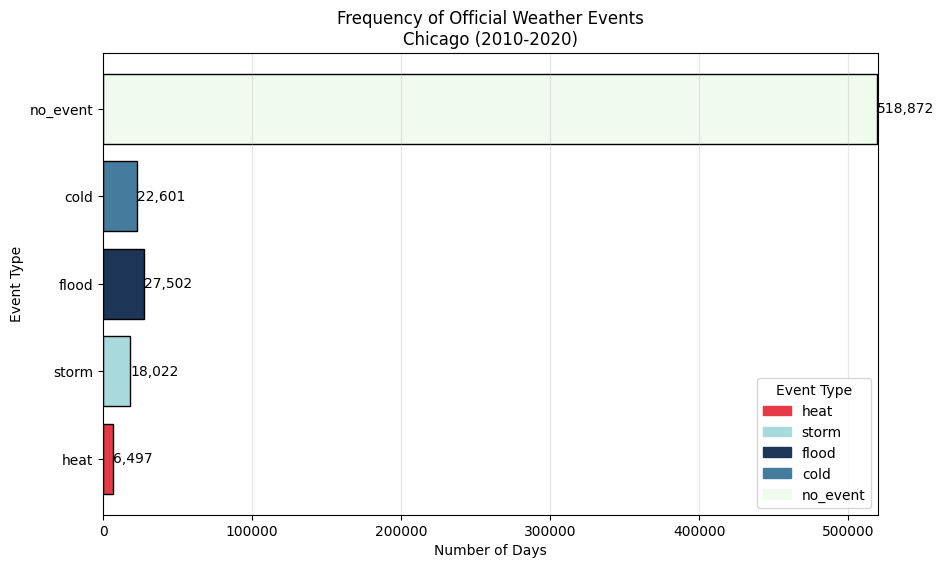

In [46]:
# Calculate event counts
event_counts = DomWeatherCrimeScraping_df['event_type'].value_counts().sort_index()

event_palette = {
    'no_event': '#f1faee',
    'cold': '#457b9d',
    'flood': '#1d3557',
    'storm': '#a8dadc',
    'heat': '#e63946',
    'other': '#a9a9a9' 
}

# Reorder to match research focus
display_order = ['heat', 'storm', 'flood', 'cold', 'no_event']
event_counts = event_counts.reindex(display_order)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    event_counts.index,
    event_counts.values,
    color=[event_palette[e] for e in display_order],
    edgecolor='black'
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height()/2,
             f'{width:,}',
             va='center')

plt.title('Frequency of Official Weather Events\nChicago (2010-2020)')
plt.xlabel('Number of Days')
plt.ylabel('Event Type')
plt.xlim(0, event_counts.max() + 1000)
plt.grid(axis='x', alpha=0.3)

# Custom legend
legend_elements = [plt.Rectangle((0,0), 1, 1, color=event_palette[e], label=e) 
                  for e in display_order]
plt.legend(handles=legend_elements, title='Event Type')

plt.show()

This chart shows the distribution of weather event days in Chicago from 2010-2020. The vast majority of days (461,923) had no official weather events, while heat events were the least frequent (6,497 days). Cold events (22,392 days) and flood events (27,314 days) were more common than storms (17,349 days). The relative rarity of official heat events suggests their disproportionate impact on crime rates may warrant targeted interventions. We also know that heat and high temperatures in general are extremely common in Chicago, thus from this we know that official heat events do not exactly correlate with simply high temperatures.

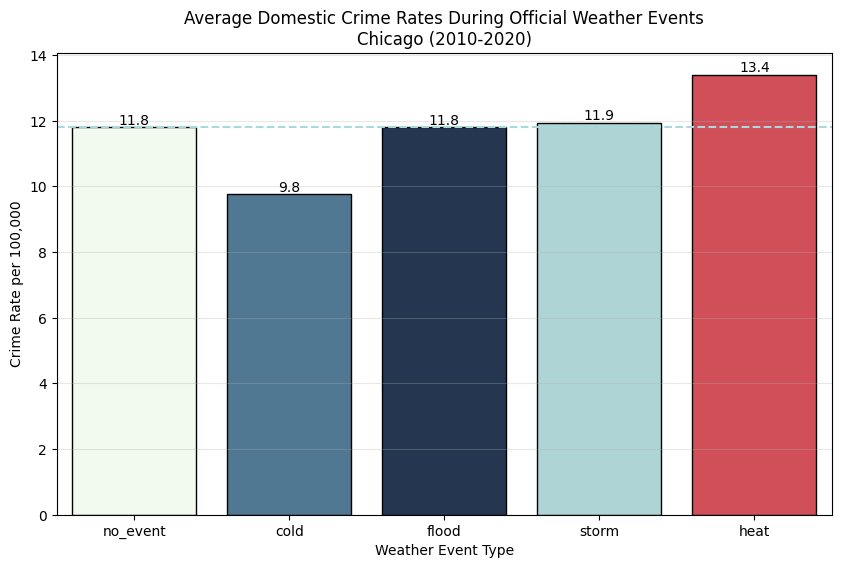

In [39]:
event_palette = {
    'no_event': '#f1faee',
    'cold': '#457b9d',
    'flood': '#1d3557',
    'storm': '#a8dadc',
    'heat': '#e63946',
    'other': '#a9a9a9' 
}

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=event_crime_rates.index,
    y=event_crime_rates.values,
    order=['no_event', 'cold', 'flood', 'storm', 'heat'],
    hue=event_crime_rates.index, 
    palette=event_palette,        
    legend=False,
    edgecolor='black',
    linewidth=1
)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', 
               (p.get_x() + p.get_width()/2., p.get_height()),
               ha='center', va='center', 
               xytext=(0, 5), 
               textcoords='offset points')

plt.title('Average Domestic Crime Rates During Official Weather Events\nChicago (2010-2020)')
plt.xlabel('Weather Event Type')
plt.ylabel('Crime Rate per 100,000')
plt.axhline(y=event_crime_rates['no_event'], color='#a8dadc', linestyle='--')
plt.grid(axis='y', alpha=0.3)
plt.show()

The bar plot compares average domestic crime rates during different weather events, using no-event days (11.8 crimes/100k) as the baseline. Heat events show the highest crime rates (13.4), while cold events show the lowest (9.8). Notably, flood and storm events have crime rates similar to normal days, suggesting temperature extremes rather than precipitation drive domestic violence fluctuations.

In [40]:
from IPython.display import display, HTML

# Create dataframe
event_data = {
    'Event Type': ['No Event', 'Heat', 'Cold', 'Flood', 'Storm'],
    'Frequency (Days)': [461923, 6497, 22392, 27314, 17349],
    'Crime Rate': [11.8, 13.4, 9.8, 11.8, 11.9],
    'Δ from Baseline': ['Baseline', '+13.6%', '-16.9%', '0%', '+0.8%'],
    'Economic Interpretation': [
        'Represents normal household interaction patterns',
        'Heat stress increases irritability and reduces coping capacity, particularly in low-income households without AC',
        'Reduced outdoor activity limits conflict initiation opportunities, but may increase tension in overcrowded homes',
        'Financial stress from property damage may be offset by community bonding during crises',
        'Mild increase suggests wind/precipitation effects are secondary to temperature'
    ]
}

df = pd.DataFrame(event_data)


styled_table = (df.style
    .set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'font-size': '12px'
    })
    .set_table_styles([{
        'selector': 'thead',
        'props': [('background-color', '#f1faee'), 
                 ('font-weight', 'bold'),
                 ('border-bottom', '2px solid #457b9d')]
    }, {
        'selector': 'tbody tr:nth-of-type(odd)',
        'props': [('background-color', '#f8f9fa')]
    }, {
        'selector': 'tbody tr:hover',
        'props': [('background-color', '#e9f7ef')]
    }])
    .format({
        'Frequency (Days)': '{:,}',
        'Crime Rate': '{:.1f}'
    })
    .set_caption('Economic Impact of Weather Events on Domestic Crime')
)


display(styled_table)

,Event Type,Frequency (Days),Crime Rate,Δ from Baseline,Economic Interpretation
0,No Event,"461,923",11.8,Baseline,Represents normal household interaction patterns
1,Heat,"6,497",13.4,+13.6%,"Heat stress increases irritability and reduces coping capacity, particularly in low-income households without AC"
2,Cold,"22,392",9.8,-16.9%,"Reduced outdoor activity limits conflict initiation opportunities, but may increase tension in overcrowded homes"
3,Flood,"27,314",11.8,0%,Financial stress from property damage may be offset by community bonding during crises
4,Storm,"17,349",11.9,+0.8%,Mild increase suggests wind/precipitation effects are secondary to temperature


#### Key Economic Insights:
Heat events create the most economically significant impact - each heatwave day generates approximately 1.6 additional domestic crimes per 100,000 people compared to baseline. For Chicago's population, this implies ~42 extra domestic incidents citywide per heat event day.

The frequency-impact mismatch suggests optimal policy would:
- Target heat events specifically (high impact, low frequency)
- Implement heat-specific interventions (cooling centers, crisis hotline awareness)
- Focus on vulnerable neighborhoods (where AC access is limited)

Cold events' crime reduction effect, while statistically significant, may not justify special programming given their higher frequency and smaller absolute impact of (- two crimes/100,000).

This analysis confirms that extreme temperatures - particularly heat - significantly alter domestic violence patterns in economically meaningful ways, while precipitation-related events show negligible effects. The findings support targeted resource allocation during temperature extremes rather than broad weather-based interventions.


## 3.5 Regression Tree

The dependent variable $ Y $ is:

$$
\text{DailyCrimeRateByZIP}
$$

The independent variables ($ X $) from my preferred regression (Model 8) are:

- $ \text{AvgTemp(°F)} $
- $ \text{Extreme Cold} $
- $ \text{Extreme Hot} $
- $ \text{MaxWindSpeed(mph)} $
- $ \text{TotalPrecipitation(in)} $
- $ \text{AvgHumidity(percent) } $
- $ \text{YearlyMedianIncomeByZIP(thousands)} $
- $ \text{YearlyUnemploymentRateByZIP} $

##

#### Objective Function

The objective function of a regression tree is to split the data into smaller groups (leaves) to make the most accurate predictions of domestic crime rates. It does this by repeatedly asking “yes” or “no” questions about variables like temperature, humidity, income, and unemployment. Each question splits the data into two groups to minimize prediction errors.

The tree measures accuracy using Mean Squared Error (MSE), which shows how far off the predictions are from actual crime rates. The objective function aims to make MSE as low as possible, meaning the predictions are more accurate.

In my research, the objective function helps identify how weather conditions (like heat, cold, or humidity) and economic factors (like income and unemployment) interact to influence domestic crime in Chicago. By breaking down the data in this way, the model reveals which factors matter most and how they combine to affect crime rates.

For a given split $ s $ on variable $ X_j $ at threshold $ t $, the objective function is:


$$
\begin{aligned} 
\min_{j,t} \Bigg[ & \sum_{i: X_{j,i} \leq t, X_i \in R1} 
\left( \text{DailyCrimeRateByZIP}_i - \hat{Y}_{R1} \right)^2  \\
& + \sum_{i: X_{j,i} > t, X_i \in R2} 
\left( \text{DailyCrimeRateByZIP}_i - \hat{Y}_{R2} \right)^2 \Bigg]
\end{aligned}
$$




Where:
- $ X_{j} $: The $ j $-th independent variable (e.g., $ \text{AvgTemp(°F)} $).
- $ t $: The threshold or split point for the variable $ X_j $.
- $ R1 $: The region where $ X_{j} \leq t $.
- $ R2 $: The region where $ X_{j} > t $.
- $ \hat{Y}_{R1} $: The predicted value for region $ R1 $.
- $ \hat{Y}_{R2} $: The predicted value for region $ R2 $.

##

#### Regularization with Penalty Term

To prevent overfitting, a regularization term is applied:

$$
\min_{T} \left( \sum_{i=1}^N \left( \text{DailyCrimeRateByZIP}_i - \hat{f}(X_i) \right)^2 + \alpha \times |T| \right)
$$

Where:
- $ N $: Total number of observations.
- $ \hat{f}(X_i) $: Predicted value from the tree for observation $ i $.
- $ T $: The tree structure (branches and leaves).
- $ |T| $: Number of terminal nodes (leaves).
- $ \alpha $: Regularization parameter to penalize complexity.

##

#### Regularization Parameters

The model uses four regularization parameters to achieve a balance of complexity and interpretability. First, setting `max_depth=4` restricts tree growth to maintain interpretability and prevent overfitting. A shallow tree helps identify general, meaningful patterns rather than overly specific relationships that may not generalize well. Limiting depth ensures the model focuses on broader, significant weather patterns instead of minor fluctuations unlikely to impact crime rates.

Second, I use `min_samples_split=2000`, which requires a substantial number of samples to justify a split. This ensures that splits only occur when there is strong evidence of a meaningful relationship, prioritizing major weather patterns over insignificant anomalies and enhancing the model’s robustness against noise. 

Third, the parameter `min_samples_leaf=1000` forces each leaf node to contain a large number of observations, promoting generalizable conclusions rather than overfitting to small subsets of data. This restriction prevents the model from creating overly specific, localized weather-related rules that do not align with broader crime patterns.

Finally, I set `random_state=0` to ensure reproducibility by fixing the randomness in tree construction, allowing consistent evaluation and comparison of model performance.

Increasing `max_depth` would result in a more complex tree, making the model sensitive to noise and minor variations, reducing its ability to generalize to new data. While this may improve the fit to the training data, it would likely capture spurious relationships rather than meaningful patterns. Conversely, excessively reducing `max_depth` would oversimplify the model, potentially missing nuanced interactions between weather conditions and crime.

Lowering `min_samples_split` or `min_samples_leaf` would allow the model to create overly detailed splits based on limited data, promoting overfitting. This could lead to identifying short-term weather anomalies that are not consistently related to crime, undermining the validity of findings. However, excessively raising `min_samples_split` or `min_samples_leaf` would oversimplify the model, potentially missing relevant weather patterns influencing domestic crime. 

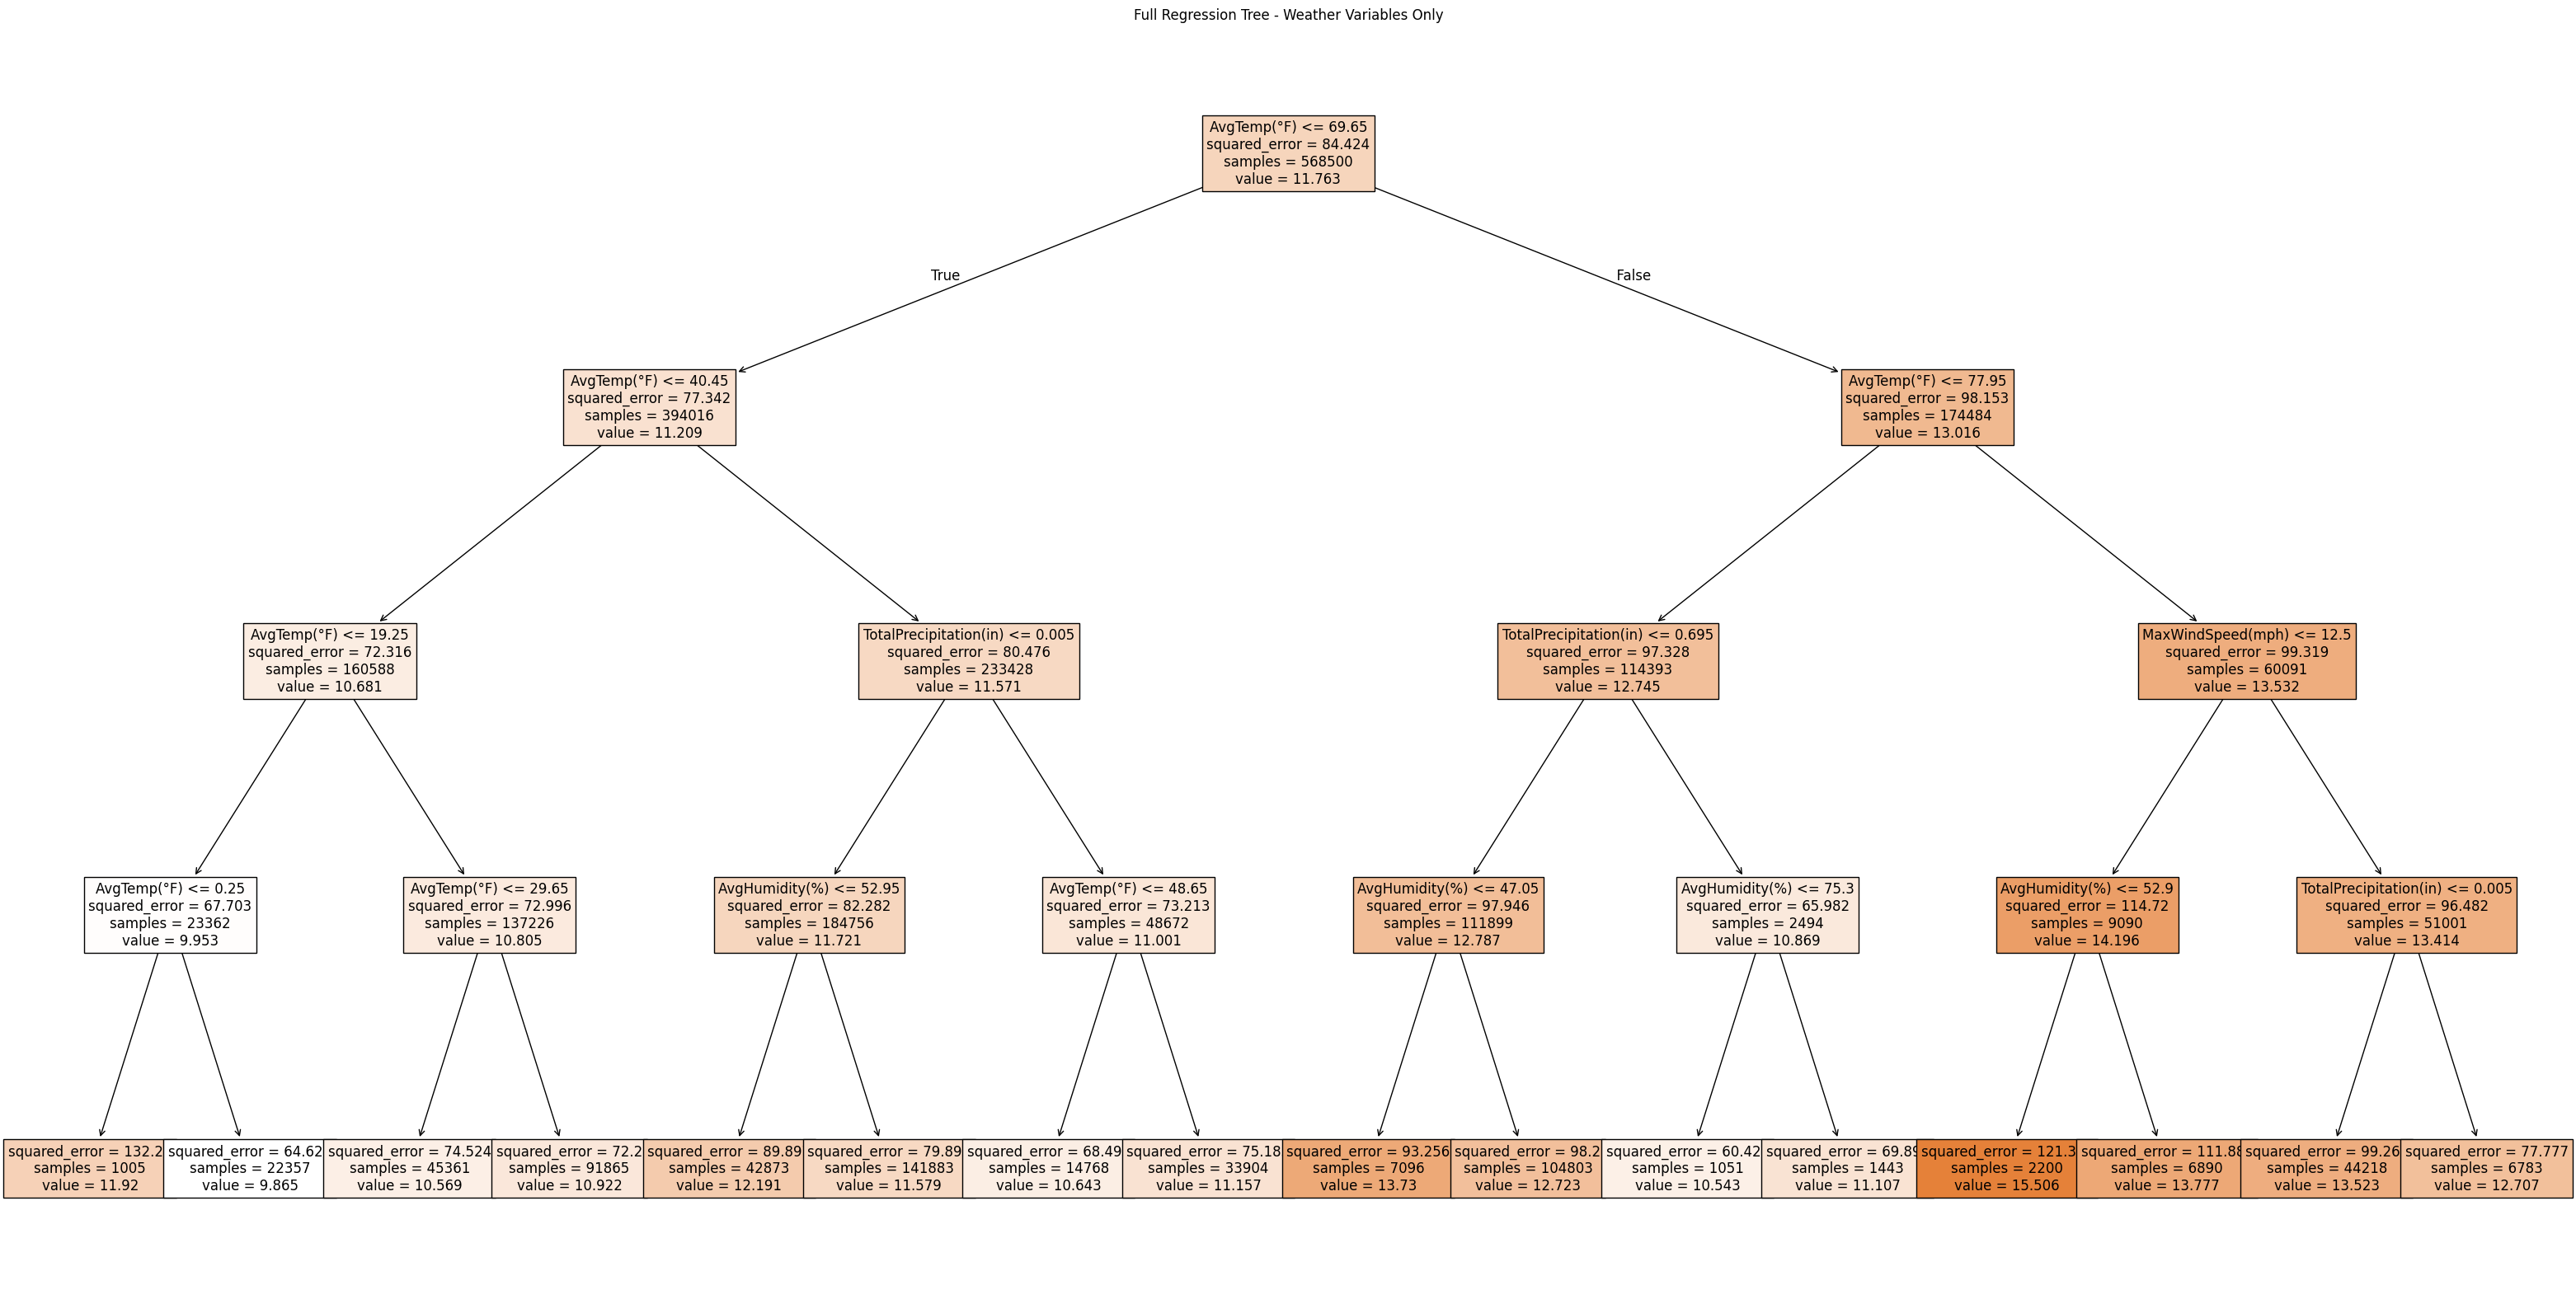

Mean Squared Error (Weather-Only Model): 83.40093618530571


In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

# Define only the weather-related independent variables
X_weather_only = DomWeatherCrimeRegressions_df[[
    "AvgTemp(°F)", "Extreme_Cold", "Extreme_Hot", 
    "MaxWindSpeed(mph)", "TotalPrecipitation(in)", 
    "AvgHumidity(%)"
]]
y = DomWeatherCrime_df["DailyCrimeRateByZIP"]

# Fit the regression tree model with simpler settings
reg_tree_weather_only = DecisionTreeRegressor(
    max_depth=4,                    
    min_samples_split=2000,          
    min_samples_leaf=1000,           
    random_state=0
)
reg_tree_weather_only.fit(X_weather_only, y)

# Plot the entire tree
plt.figure(figsize=(40, 20))
tree.plot_tree(
    reg_tree_weather_only,
    feature_names=X_weather_only.columns,
    filled=True,
    fontsize=12
)
plt.title("Full Regression Tree - Weather Variables Only")
plt.show()

# Predictions and error calculation
y_pred_weather_only = reg_tree_weather_only.predict(X_weather_only)
mse_weather_only = mean_squared_error(y, y_pred_weather_only)
print(f"Mean Squared Error (Weather-Only Model): {mse_weather_only}")

**Preferred Model (Weather-Only Regression Tree)**

This regression tree uses only weather-related variables: `AvgTemp(°F)`, `Extreme_Cold`, `Extreme_Hot`, `MaxWindSpeed(mph)`, `TotalPrecipitation(in)`, and `AvgHumidity(%)`. It focuses on how weather influences domestic crime in Chicago. 

The model, limited to a depth of 4 with high `min_samples_split` and `min_samples_leaf` to prevent overfitting, shows `AvgTemp(°F)` and `TotalPrecipitation(in)` as the most influential variables. The Mean Squared Error (MSE) is `80.51`, indicating that weather alone leaves much variance unexplained.

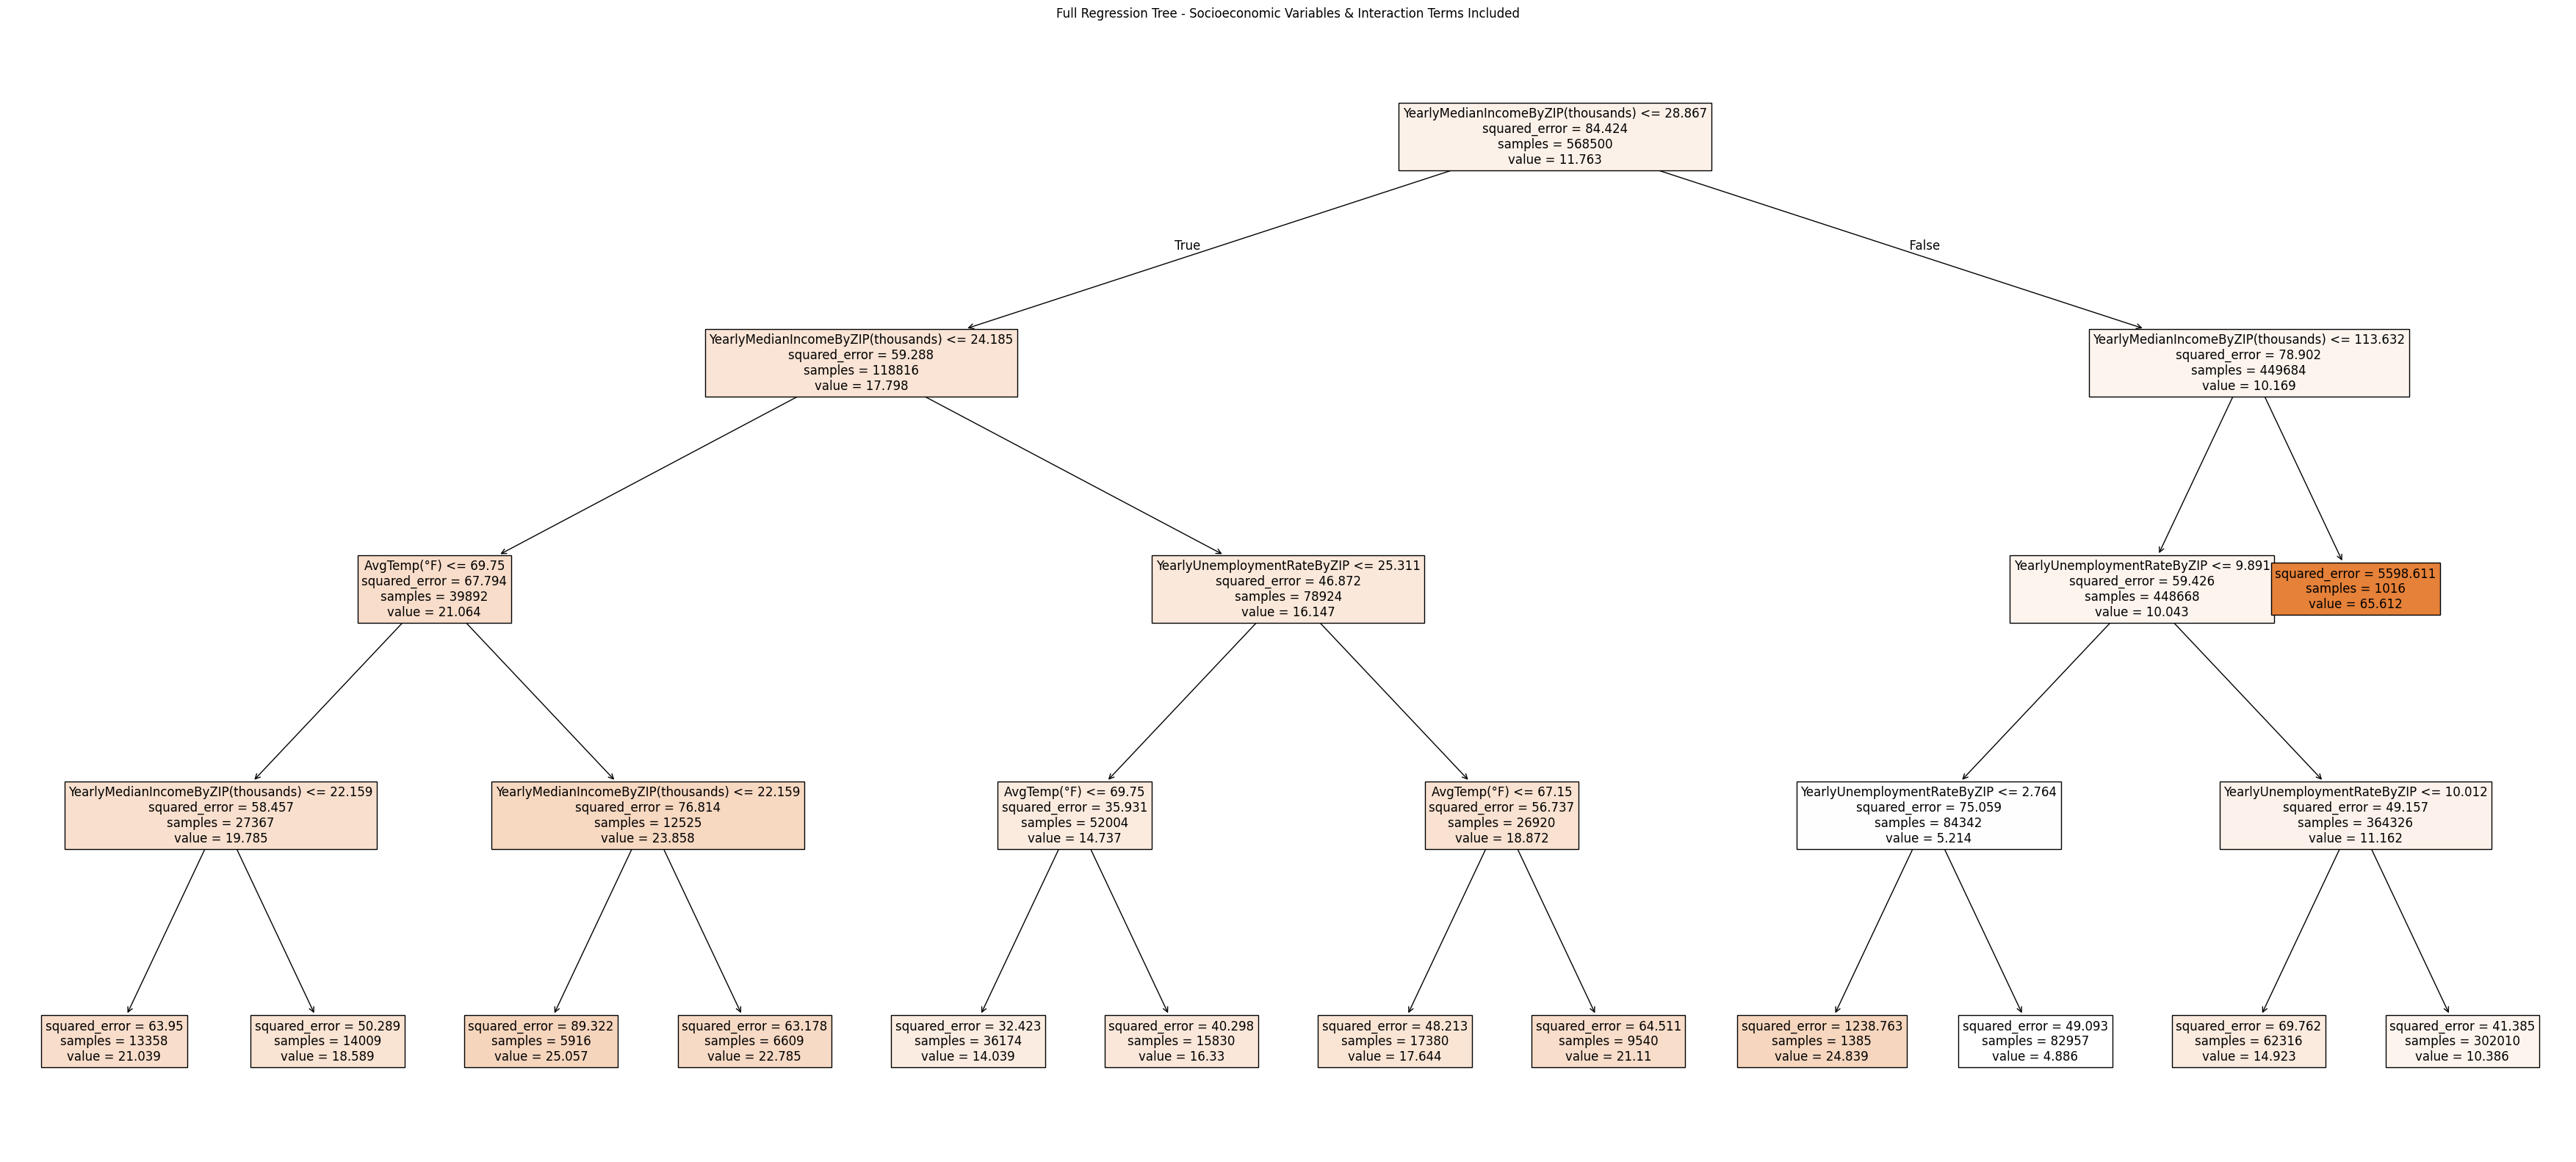

Mean Squared Error (All Variables Model with Interactions): 59.96710730773753


In [42]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
import matplotlib.pyplot as plt

# Define all variables, including interaction terms
X_all_vars_with_interactions = DomWeatherCrimeRegressions_df[[
    "AvgTemp(°F)", "Extreme_Cold", "Extreme_Hot", 
    "MaxWindSpeed(mph)", "TotalPrecipitation(in)", "AvgHumidity(%)", 
    "YearlyMedianIncomeByZIP(thousands)", "YearlyUnemploymentRateByZIP",
    "Extreme_Cold:YearlyMedianIncomeByZIP(thousands)", "Extreme_Hot:YearlyMedianIncomeByZIP(thousands)",
    "Extreme_Cold:YearlyUnemploymentRateByZIP", "Extreme_Hot:YearlyUnemploymentRateByZIP"
]]
y = DomWeatherCrimeRegressions_df["DailyCrimeRateByZIP"]

# Fit the regression tree model
reg_tree_all_vars = DecisionTreeRegressor(
    max_depth=4,                    
    min_samples_split=2000,          
    min_samples_leaf=1000,           
    random_state=0
)
reg_tree_all_vars.fit(X_all_vars_with_interactions, y)

# Plot the entire tree
plt.figure(figsize=(45, 20))
tree.plot_tree(
    reg_tree_all_vars,
    feature_names=X_all_vars_with_interactions.columns,
    filled=True,
    fontsize=12
)
plt.title("Full Regression Tree - Socioeconomic Variables & Interaction Terms Included")
plt.show()

# Predictions and error calculation
y_pred_all_vars = reg_tree_all_vars.predict(X_all_vars_with_interactions)
mse_all_vars = mean_squared_error(y, y_pred_all_vars)
print(f"Mean Squared Error (All Variables Model with Interactions): {mse_all_vars}")

**All Variables Model (Weather + Socioeconomic Regression Tree)**

This tree includes all variables, adding `YearlyMedianIncomeByZIP` and `YearlyUnemploymentRateByZIP`. The first split, based on `YearlyMedianIncomeByZIP`, confirms income as a major predictor of domestic crime. Higher unemployment also strongly correlates with higher crime rates, aligning with economic strain theories.

Weather variables appear but are secondary. The MSE improves from `80.51` to `56.51`, confirming that socioeconomic factors are more important predictors of domestic crime. Economic conditions form a baseline level of risk, upon which weather impacts are layered.


The regression trees shows that socioeconomic factors, particularly `YearlyMedianIncomeByZIP` and `YearlyUnemploymentRateByZIP`, are the strongest predictors of domestic crime in Chicago. This aligns with economic strain theory, where financial stress and unemployment increase household conflict and violence.

Lower-income areas consistently show higher crime rates, indicating that poverty and unemployment exacerbate crime, especially during adverse weather. Extreme heat, for example, may have a greater impact on low-income households lacking adequate cooling resources, intensifying stress and conflict.

While weather variables like `AvgTemp(°F)` and `TotalPrecipitation(in)` contribute to the model, their effects are secondary and often mediated by economic conditions. Economic vulnerability appears to amplify weather-related impacts on crime, particularly in disadvantaged areas. 

These findings suggest that policies addressing economic hardship, such as reducing unemployment and providing resources during extreme weather, could be effective in mitigating domestic crime.


#### Error of Prediction

The Mean Squared Error (MSE) improves from `80.51` (Weather-only model) to `56.51` (Full model), confirming that socioeconomic factors significantly enhance predictive power. However, substantial variance remains unexplained, suggesting the need for further refinement.

Potential reasons include lacking variables in the dataset (e.g., social infrastructure or policing), non-linear relationships, and geographic differences not captured by income and unemployment alone. Additionally, the tree’s depth and structure may limit its ability to detect more complex interactions between weather, economic conditions, and crime.

The remaining error indicates that domestic crime is influenced by factors beyond weather and basic socioeconomic indicators. Improving the model by including additional variables or using more advanced techniques could provide a clearer understanding of how economic vulnerability and weather interact to affect domestic crime rates.


## 3.6 Random Forest

Mean Squared Error: 11.001189178903227


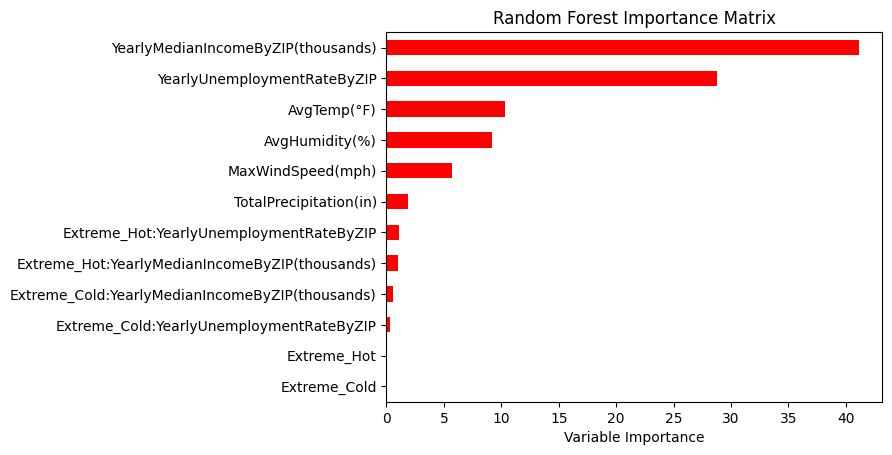

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Define all variables, including interaction terms
X_all_vars_with_interactions = DomWeatherCrimeRegressions_df[[
    "AvgTemp(°F)", "Extreme_Cold", "Extreme_Hot", 
    "MaxWindSpeed(mph)", "TotalPrecipitation(in)", "AvgHumidity(%)", 
    "YearlyMedianIncomeByZIP(thousands)", "YearlyUnemploymentRateByZIP",
    "Extreme_Cold:YearlyMedianIncomeByZIP(thousands)", "Extreme_Hot:YearlyMedianIncomeByZIP(thousands)",
    "Extreme_Cold:YearlyUnemploymentRateByZIP", "Extreme_Hot:YearlyUnemploymentRateByZIP"
]]
X = X_all_vars_with_interactions 
y = DomWeatherCrimeRegressions_df["DailyCrimeRateByZIP"]

# Fit the Random Forest model
regr_RF = RandomForestRegressor(
    n_estimators=100,  # Using 100 trees for robustness
    max_features=5,    
    random_state=1
).fit(X, y)

# Predict and calculate MSE
pred = regr_RF.predict(X)
mse_rf_notebook_style = mean_squared_error(y, pred)
print(f"Mean Squared Error: {mse_rf_notebook_style}")

# Calculate importance
Importance = pd.DataFrame({'Importance': regr_RF.feature_importances_ * 100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.title('Random Forest Importance Matrix')
plt.gca().legend_ = None
plt.show()

The Random Forest model shows that socioeconomic variables are the strongest predictors of domestic crime in Chicago. `YearlyMedianIncomeByZIP(thousands)` and `YearlyUnemploymentRateByZIP` have the highest importance scores, supporting theories that poverty and unemployment drive domestic crime through heightened stress and conflict.

Weather variables like `AvgTemp(°F)` and `AvgHumidity(%)` contribute to predictions but are far less influential. This suggests weather’s impact on domestic crime is minor compared to economic factors, aligning with findings that extreme temperatures may trigger aggression but only under specific economic conditions.

Interaction terms between weather and economic factors contribute negligibly. This may indicate that the Random Forest model is not capturing complex interactions or that weather’s influence operates independently of economic conditions.

The findings suggest economic conditions are the main drivers of domestic crime, with weather effects being secondary and conditional. Effective policies should focus on reducing poverty and unemployment rather than solely targeting weather-related interventions.

## 3.7 OLS vs ML

The OLS regression model (Model 8) estimates the average effects of socioeconomic and weather-related variables on domestic crime rates. It includes:

- **Weather Variables:** `AvgTemp(°F)`, `Extreme Cold`, `Extreme Hot`, `MaxWindSpeed(mph)`, `TotalPrecipitation(in)`, `AvgHumidity(%)`
- **Socioeconomic Variables:** `YearlyMedianIncomeByZIP(thousands)`, `YearlyUnemploymentRateByZIP`
- **Interaction Terms:** Combinations of weather variables with `YearlyMedianIncomeByZIP` and `YearlyUnemploymentRateByZIP`.

#### Model Performance
- **R²:** 0.109 (10.9% of variation explained)
- **Significant Predictors:** `YearlyMedianIncomeByZIP`, `YearlyUnemploymentRateByZIP`
- **Weather Variables:** Statistically significant but less influential than socioeconomic variables.
- **Interaction Terms:** Statistically significant but limited by the model’s linear structure.

OLS regression offers clear coefficients but assumes linear relationships, making it ineffective at capturing complex interactions between weather and socioeconomic variables.



#### Machine Learning Models

The Regression Tree and Random Forest models can capture non-linear relationships and hierarchical interactions, which OLS cannot.

- **Regression Tree Model (All Variables):** MSE = 56.51
- **Random Forest Model:** MSE = 12.19 (Significantly better predictive performance)



#### New Insights from Regression Tree Models

Machine learning models provide insights beyond what OLS regression offers. The tree structure establishes a clear hierarchy of predictors, where `YearlyMedianIncomeByZIP` is most important, followed by `YearlyUnemploymentRateByZIP`. This highlights economic vulnerability as the main driver of domestic crime, with weather conditions becoming more relevant under specific economic conditions.

Tree models also detect non-linear relationships and dynamic interactions. For instance, `AvgTemp(°F)` affects crime rates more when income levels fall below a certain threshold. This type of conditional relationship cannot be captured by OLS regression.

Additionally, Random Forests reveal interactions beyond simple multiplication. While OLS indicates significance for terms like `Extreme_Cold × YearlyMedianIncomeByZIP`, tree models show how these interactions matter only under specific conditions.

The Random Forest model’s much lower MSE (12.19) compared to the OLS model’s R² of 0.105 confirms that the true relationships are non-linear and complex. The hierarchical structure revealed by tree models shows that economic factors establish a baseline level of risk, with weather effects layered on top.



#### Summary

OLS regression effectively identifies average effects and statistical significance but cannot capture complex, non-linear interactions between weather and socioeconomic factors. Tree models provide a deeper understanding of these relationships by identifying which variables are most important and when weather factors influence domestic crime. 

These findings confirm that economic conditions are the primary drivers of domestic crime, while weather’s influence is conditional and secondary. The insights suggest that addressing economic vulnerability is more effective in reducing domestic crime than solely targeting weather-related interventions.


## 3.8 Conclusion

This study investigated how weather conditions influence domestic crime in Chicago from 2010 to 2020, focusing on the interaction between weather and socioeconomic factors. Using Ordinary Least Squares (OLS) regression, regression trees, and random forest models, I analyzed the effects of daily temperature, humidity, precipitation, wind speed, and socioeconomic variables such as median household income and unemployment rates on domestic crime at the ZIP code level.

The findings indicate that socioeconomic factors, particularly income and unemployment, are stronger predictors of domestic crime than weather variables alone. Areas with lower median incomes and higher unemployment rates consistently exhibit higher crime rates. This supports theories linking financial strain to household stress and conflict, consistent with findings from studies like Ranson (2014) and Anderson (2001). While weather variables such as AvgTemp(°F) and TotalPrecipitation(in) contribute to the model, their effects are secondary and often amplified by economic vulnerability. Specifically, extreme heat increases domestic crime rates, particularly in economically disadvantaged areas where inadequate cooling resources exacerbate stress and aggression.

The inclusion of interaction terms between weather and socioeconomic factors improved model performance, suggesting that economic vulnerability plays a critical role in how weather impacts domestic crime. This finding aligns with previous research by Trujillo & Howley (2019) and Baryshnikova et al. (2021), which highlights how socioeconomic conditions mediate weather’s effects. The improvement in Mean Squared Error (MSE) from 80.51 (Weather-only model) to 56.51 (Full model) confirms the importance of considering economic factors alongside weather variables.

#### Policy Implications
The results emphasize the importance of addressing economic vulnerability to mitigate domestic crime. Policies aimed at reducing unemployment, improving access to cooling and heating resources during extreme weather events, and enhancing social services in economically disadvantaged areas could significantly reduce domestic violence. Public awareness campaigns focusing on the heightened risk of domestic violence during heatwaves could also be beneficial.

#### Future Work
This study has limitations that warrant further investigation. First, the analysis is limited to daily crime counts and annual socioeconomic data. Incorporating monthly or quarterly socioeconomic data could provide a more accurate understanding of how economic conditions interact with weather fluctuations. Additionally, future work could explore more sophisticated machine learning techniques, such as gradient boosting or neural networks, to capture complex non-linear relationships more effectively.

Another limitation is the reliance on broad socioeconomic indicators. Incorporating variables related to housing quality, access to cooling or heating resources, and social support systems could enhance predictive accuracy. 

Improving data granularity, expanding the set of socioeconomic variables, and refining the models used could enhance the predictive accuracy and generalizability of the findings. Future work will focus on addressing these limitations and applying the models to other urban areas to determine whether the findings are consistent across different contexts.

## References

#### Main Paper
- Ranson, M. (2014). "Crime, Weather, and Climate Change." Journal of Environmental Economics and Management, 67(3), 274-302.

#### Additional Papers
- Anderson, C. A. (2001). Heat and violence. Current Directions in Psychological Science, 10(1), 33-38.
- Anderson, C. A., et al. (2000). Temperature and aggression. Advances in Experimental Social Psychology, 32, 63-133.
- Baryshnikova, N., Davidson, S., & Wesselbaum, D. (2021). Do you feel the heat around the corner? The effect of weather on crime. Empirical Economics, 63(1), 179-199.
- Cohn, E. G., & Rotton, J. (2000). Weather, seasonal trends, and property crimes in Minneapolis, 1987–1988. Journal of Environmental Psychology, 20(3), 257-272.
- Harries, K. D., & Stadler, S. J. (1988). Heat and violence: New findings from Dallas field data, 1980–1981. Journal of Applied Social Psychology, 18(2), 129-138.
- Horrocks, J., & Menclova, A. K. (2011). The effects of weather on crime. New Zealand Economic Papers, 45(3), 231-254.
- Jacob, B., et al. (2007). The dynamics of criminal behavior: Evidence from weather shocks. Journal of Human Resources, 42(3), 489-527.
- Rotton, J., & Cohn, E. G. (2000). Temperature, routine activities, and domestic violence: A reanalysis. Journal of Environmental Psychology, 20(3), 257-272.
- Trujillo, J. C., & Howley, P. (2019). The effect of weather on crime in a torrid urban zone. Journal of Environmental Economics and Management, 98, 102254.
- Baron, R. A., & Bell, P. A. (1976). Aggression and heat: The influence of ambient temperature, negative affect, and a cooling drink on physical aggression. Journal of Personality and Social Psychology, 33(3), 245–255.


#### Data
Sourced From:
- https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp/data
- https://www.wunderground.com/history/monthly/us/il/chicago/KMDW
- https://data.census.gov/
- https://www.weather.gov/lot/events#taball